In [4]:
import pickle
import torch
import matplotlib.pyplot as plt
import matplotlib
from scipy import stats
import os
import numpy as np
import sys
import pandas as pd 
from tqdm import tqdm
sys.path.append("../../../..")
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as mpatches
from datasets.morpho_mnist.dataset import ImageDataset, MetadataDataset, TripletDataset
from auto_localization.models.BasicVAE import BasicVAE
from auto_localization.experiment_management.basic_experiment import BasicExperiment
from auto_localization.experiment_management.hyperparameter_experiment import HyperparameterExperiment
from auto_localization.dataset_management.data_manager import DataManager
from auto_localization.plotting.localization import save_localization_metadata_distance_plots
from auto_localization.oracles.metadata_oracle import MetadataOracle
from auto_localization.oracles.indexed_metadata_oracle import IndexedMetadataOracle
from auto_localization.training.training_test import reconstruction_of_metadata
from datasets.morpho_mnist.measure import measure_image
from auto_localization.localization.localization_experiment_manager import LocalizationExperimentManager
from auto_localization.plotting.localization import embedding_with_posterior_path, embedding_with_planes
import auto_localization.plotting.localization as localization_plotting
import auto_localization.plotting.image_sampling as image_sampling

In [5]:
"""
    Function that loads a model from a given path.
"""
def load_model_and_config(model_dir):
    # load params from model_dir
    with open(model_dir+"/params.pkl", "rb") as f:
        config = pickle.load(f)
        print("Config object:")
        print(config)
    # load model
    model_path = model_dir+"/model.pkl"
    z_dim = config["model_config"]["latent_dim"]
    in_shape = config["model_config"]["in_shape"]
    d = config["model_config"]["d"]
    layer_count = config["model_config"]["layer_count"]
    channels = config["model_config"]["channels"]
    model = BasicVAE(z_dim = z_dim, in_shape = in_shape, d = d, layer_count=layer_count, channels=channels)
    #model = BasicVAE(z_dim = z_dim, in_shape = in_shape, d = d, layer_count=layer_count, channels=channels, loss_name="GlobalMaskVAETripletLoss")
    model.load_state_dict(torch.load(model_path))
    model.to("cuda")
    model.eval()
        
    return model, config

In [6]:
model_dir = "../../../logs/deep-forest-7671"
model, config = load_model_and_config(model_dir)
experiment_config = config
experiment_config["trials"] = 5
experiment_config["model_config"]["triplet_beta"] = [0.0, 1.0]
print(experiment_config)

Config object:
{'trials': 1, 'epochs': 50, 'lr': 0.001, 'batch_size': 512, 'trainer': 'triplet', 'group': 'thickness_slant_localization_5', 'localization_config': {'indexed': False, 'trials': 20, 'k': 1.0, 'localizer_type': ['MCMV', 'Random'], 'num_queries': 50, 'similarity_mode': False}, 'model_config': {'model_type': 'BasicVAE', 'latent_dim': 2, 'in_shape': 32, 'd': 32, 'layer_count': 4, 'channels': 1, 'loss_name': 'VAETripletLoss', 'kl_beta': 0.01, 'triplet_beta': 0.0, 'triplet_margin': 1.0, 'warm_start': 30, 'kl_max': 0.01, 'triplet_mining': False}, 'dataset_config': {'dataset_name': 'MorphoMNIST', 'component_weighting': [0.0, 0.0, 3.0, 1.0, 0.0, 0.0], 'localization_component_weighting': [0.0, 0.0, 3.0, 1.0, 0.0, 0.0], 'which_digits': [1], 'one_two_ratio': 0.0, 'batch_size': 512}}
{'trials': 5, 'epochs': 50, 'lr': 0.001, 'batch_size': 512, 'trainer': 'triplet', 'group': 'thickness_slant_localization_5', 'localization_config': {'indexed': False, 'trials': 20, 'k': 1.0, 'localizer_ty

In [7]:
def setup_data_manager(config):
    which_digits = config["dataset_config"]["which_digits"]
    component_weighting = config["dataset_config"]["component_weighting"]
    one_two_ratio = config["dataset_config"]["one_two_ratio"]
    metadata_dataset = MetadataDataset(train=False, which_digits=which_digits, apply_transform=False)
    test_metadata_dataset = MetadataDataset(train=False, which_digits=which_digits, apply_transform=False)
    localization_oracle = MetadataOracle(metadata_dataset=metadata_dataset, component_weighting=component_weighting)
    test_metadata_oracle = IndexedMetadataOracle(
            metadata_dataset=test_metadata_dataset,
            component_weighting=component_weighting
    )
    triplet_train_dataset = TripletDataset(train=True, which_digits=which_digits, oracle=localization_oracle, one_two_ratio=one_two_ratio)
    triplet_test_dataset = TripletDataset(train=False, which_digits=which_digits, oracle=test_metadata_oracle, one_two_ratio=one_two_ratio)
    image_train_dataset = ImageDataset(train=True, which_digits=which_digits)
    image_test_dataset = ImageDataset(train=False, which_digits=which_digits)
    data_manager = DataManager((image_train_dataset, image_test_dataset), (triplet_train_dataset, triplet_test_dataset))
    
    return data_manager
data_manager = setup_data_manager(experiment_config)

In [8]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

### Evaluate the noise model

In [9]:
def calculate_noise_model_difference(k_constant, num_test_iters=10):
    # go through the triplet dataset
    # for each triplet get a binary answer of whether or not the dataset is satisfied by the space
    triplet_response_probability = []
    is_correct = []
    for test_iter in range(num_test_iters):
        for triplet_index in tqdm(range(len(data_manager.triplet_test))):
            (anchor, positive, negative), [] = data_manager.triplet_test[triplet_index]
            # embed the triplets
            _, _, anchor_vector, _ = model.forward(anchor.cuda())
            _, _, positive_vector, _ = model.forward(positive.cuda())
            _, _, negative_vector, _ = model.forward(negative.cuda())
            anchor_vector = anchor_vector.detach().cpu().numpy()
            positive_vector = positive_vector.detach().cpu().numpy()
            negative_vector = negative_vector.detach().cpu().numpy()
            # calculate the probability given by the logistic response model that the positive
            # vector will be the correct one
            anchor_neg = np.linalg.norm(anchor_vector - negative_vector)**2
            anchor_pos = np.linalg.norm(anchor_vector - positive_vector)**2
            is_correct.append(1.0 if anchor_neg > anchor_pos else 0.0)
            probability =  sigmoid(k_constant*(anchor_neg - anchor_pos))
            if probability < 0.5:
                probability = 1.0 - probability
            triplet_response_probability.append(probability)
    # true probability is 1.0
    print(triplet_response_probability)
    # calculate mean
    is_correct = np.mean(is_correct)
    mean_prob = np.mean(triplet_response_probability)
    std_prob = np.std(triplet_response_probability)
    # minimize this difference
    return mean_prob, std_prob, is_correct

In [10]:
mean_probs = []
std_probs = []
is_corrects = []
k_constants = np.logspace(-3, 5, num=100)
for k_constant in tqdm(k_constants):
    mean_prob, std_prob, is_correct = calculate_noise_model_difference(k_constant, num_test_iters=5)
    is_corrects.append(is_correct)
    mean_probs.append(mean_prob)
    std_probs.append(std_prob)

100%|██████████| 1135/1135 [00:05<00:00, 191.56it/s]

100%|██████████| 1135/1135 [00:05<00:00, 196.72it/s]

100%|██████████| 1135/1135 [00:05<00:00, 199.03it/s]

100%|██████████| 1135/1135 [00:05<00:00, 199.06it/s]

  2%|▏         | 21/1135 [00:00<00:05, 202.39it/s]

[0.5000951450504848, 0.50053691240056, 0.5007606640022495, 0.5001484225557136, 0.5012019222835182, 0.5008029829227916, 0.5007229200119556, 0.5007474460314617, 0.5009452287833892, 0.5000116672950603, 0.5015966183124235, 0.5011305456775702, 0.5015932834130972, 0.5008332899790549, 0.5009907548327255, 0.5000354302512179, 0.5018483876840363, 0.5001981845788411, 0.5008188852942688, 0.5009994540104115, 0.5005460957805719, 0.5000548000233858, 0.5004424352718412, 0.5017937808070824, 0.5007495432510272, 0.5002301958182793, 0.5009229192697826, 0.5008436248762684, 0.5006258035591769, 0.5010724277109176, 0.5002004373534481, 0.5001573528616284, 0.5001195970561501, 0.5007884692858836, 0.5018858620157571, 0.5003507125062834, 0.500472666786627, 0.500761300049552, 0.5006975083953376, 0.500435804223375, 0.5005024543317089, 0.5006596731453792, 0.5003070554277973, 0.5018187329111056, 0.5005179943144222, 0.5001566073701496, 0.5015132759565872, 0.5000559502993993, 0.5003053525604639, 0.5011801501972769, 0.50


100%|██████████| 1135/1135 [00:05<00:00, 195.09it/s]

100%|██████████| 1135/1135 [00:05<00:00, 199.04it/s]

100%|██████████| 1135/1135 [00:05<00:00, 199.30it/s]

100%|██████████| 1135/1135 [00:05<00:00, 196.89it/s]

  2%|▏         | 21/1135 [00:00<00:05, 202.97it/s]

[0.5001085040137865, 0.5002039146884127, 0.5001756263473985, 0.501407548659837, 0.5008389492498367, 0.5004410663132675, 0.5004797871464866, 0.5000835191537358, 0.5066256472208825, 0.5009145960374485, 0.5030903244474572, 0.5000976693468832, 0.5000836331292265, 0.5008305653762563, 0.5004733058183779, 0.5002056799048233, 0.5023180972618668, 0.5007973545062376, 0.5001460161485647, 0.5010918393974461, 0.500708967940343, 0.5017588274331007, 0.5001588458528904, 0.5002451703913029, 0.5014703990131457, 0.5022733650161713, 0.5021513022211519, 0.5000364188017636, 0.5008644803852931, 0.501751829280645, 0.5016596521836258, 0.5006236042010648, 0.5001388521138074, 0.5003529345865654, 0.5009194703638464, 0.5009143490642181, 0.5003567277532435, 0.5012633440318539, 0.5006267093235002, 0.5009337420665674, 0.5008557336721365, 0.5006295472969992, 0.501510860872756, 0.50020672793223, 0.5014126966638448, 0.5000677049247042, 0.5007631419108419, 0.502219831492975, 0.5004372524060221, 0.5003682610660145, 0.5002


100%|██████████| 1135/1135 [00:05<00:00, 199.84it/s]

100%|██████████| 1135/1135 [00:05<00:00, 197.10it/s]

100%|██████████| 1135/1135 [00:05<00:00, 197.87it/s]

100%|██████████| 1135/1135 [00:05<00:00, 198.84it/s]

  2%|▏         | 21/1135 [00:00<00:05, 201.58it/s]

[0.5009769951840479, 0.5023335829178164, 0.5001381090272404, 0.5000086892067472, 0.5023402908836411, 0.5001154230799045, 0.5002352115217101, 0.5003020590724502, 0.5015272530599306, 0.500106695508715, 0.5012008632969334, 0.5000515429314352, 0.5030428752087865, 0.5011442670242865, 0.500483668813351, 0.500083127799807, 0.5002578367012651, 0.5002081586465026, 0.5021846636235404, 0.5004555532486001, 0.5010470109155317, 0.500794427779439, 0.5020560625243374, 0.5010742222280937, 0.502837717291753, 0.5012019945400671, 0.5016550239601086, 0.5008613033293853, 0.501559430687561, 0.5012550782842533, 0.5008498905675932, 0.5025606496030007, 0.5010890451299885, 0.5008720537847916, 0.501182291666897, 0.501612544110027, 0.5007005345676707, 0.5011320201831685, 0.5004218285063838, 0.5005381645132554, 0.5003931170381546, 0.5006434799293319, 0.5011433917713131, 0.5008116353167356, 0.5013906966711523, 0.5006052116545073, 0.5002660170574552, 0.5011564250293503, 0.5000774066507286, 0.5002328396286551, 0.50152


100%|██████████| 1135/1135 [00:05<00:00, 198.42it/s]

100%|██████████| 1135/1135 [00:05<00:00, 198.09it/s]

100%|██████████| 1135/1135 [00:05<00:00, 197.74it/s]

100%|██████████| 1135/1135 [00:05<00:00, 193.66it/s]

  2%|▏         | 21/1135 [00:00<00:05, 201.18it/s]

[0.5001640221299212, 0.5013307480484066, 0.5011639626927306, 0.5011954952627126, 0.5017636488772912, 0.501071951546996, 0.5000662940092014, 0.5000387914761505, 0.5016368168690675, 0.5006062182150495, 0.5015749642544558, 0.5022443435064776, 0.5003630749950738, 0.5061592288632881, 0.5011106151370498, 0.5016343167153187, 0.5065345107064774, 0.5021236254648249, 0.5016067326267248, 0.5001705591280349, 0.5003968317748472, 0.5009461960617405, 0.5001450817166052, 0.500645123851957, 0.5001030179548523, 0.5002718701641748, 0.5074093295825165, 0.5025961206507813, 0.5008082582715369, 0.500043321539128, 0.5002306383250984, 0.5002030409233864, 0.5000499442391895, 0.5001710756221305, 0.5004769086223287, 0.5022253359672131, 0.5018802253687377, 0.5004051970681543, 0.5009183736732988, 0.502415888928918, 0.5004006077830606, 0.5005393165840494, 0.5035360916614073, 0.5002822298954126, 0.5011309798195812, 0.5008175850413824, 0.5021662015799524, 0.5052550575461043, 0.5033697792879618, 0.5013116019152722, 0.5


100%|██████████| 1135/1135 [00:05<00:00, 198.72it/s]

100%|██████████| 1135/1135 [00:05<00:00, 198.32it/s]

100%|██████████| 1135/1135 [00:05<00:00, 197.61it/s]

100%|██████████| 1135/1135 [00:05<00:00, 196.52it/s]

  2%|▏         | 21/1135 [00:00<00:05, 201.52it/s]

[0.5008060674586572, 0.503517148320353, 0.5013889486168959, 0.5009442574769807, 0.5020748270017573, 0.5026518739114569, 0.5002505602364024, 0.5003181022156385, 0.5017233031856039, 0.5005957950830062, 0.5005294741545355, 0.5001385305900259, 0.503217250555868, 0.5044110695090529, 0.5009543946723138, 0.5004321994498672, 0.5045789417189422, 0.5004457284510464, 0.5030442376640372, 0.5006655202871299, 0.5050747362184748, 0.5001314829928567, 0.500420868072809, 0.5001958238005211, 0.5007626117778422, 0.5002176135752314, 0.5007894727058583, 0.5007102315961559, 0.5049104355433301, 0.5026739906242459, 0.5020471757983846, 0.5003429348307128, 0.5000397396540395, 0.502590645299172, 0.501843662835645, 0.503954051059514, 0.5089803722638141, 0.5016254836299479, 0.5022554678623705, 0.5000633926843626, 0.5020438740723862, 0.5017499632713079, 0.5044323381148438, 0.5012038425370011, 0.500535380626244, 0.5035756485478702, 0.5013362544870117, 0.5031000395058786, 0.5010339475112348, 0.5037275755062199, 0.5005


100%|██████████| 1135/1135 [00:05<00:00, 198.33it/s]

100%|██████████| 1135/1135 [00:05<00:00, 197.82it/s]

100%|██████████| 1135/1135 [00:05<00:00, 197.61it/s]

100%|██████████| 1135/1135 [00:05<00:00, 198.45it/s]

  2%|▏         | 21/1135 [00:00<00:05, 201.18it/s]

[0.5002327831347182, 0.5009222788127341, 0.5008731113627986, 0.5003679672343361, 0.5031624148749689, 0.5033023573623268, 0.5004483869362473, 0.5007704236073782, 0.5055132265243926, 0.5004550306059036, 0.5005393108613521, 0.5008130877026938, 0.5011803921631189, 0.5039130026963131, 0.5001566689638938, 0.500986392026582, 0.5000000802931669, 0.5009951461665733, 0.5005594935278973, 0.5000115211257679, 0.500914292258269, 0.5007009443777962, 0.5021878850535952, 0.5011689140944019, 0.5000123075357581, 0.5004959941813997, 0.5007572115489042, 0.5019740293779477, 0.5021829861055, 0.5016004131276169, 0.5000625380910394, 0.5000331971873392, 0.5025987480941478, 0.5001398076471794, 0.5027261136163973, 0.5004443142428292, 0.5006818450056696, 0.5010721645843667, 0.5003981359211171, 0.5053843133766613, 0.5002162319785441, 0.5003232499712162, 0.5085186614132213, 0.5001203772098111, 0.503393655464584, 0.5009359461340782, 0.5002977555090671, 0.5000349048989587, 0.5029189960283609, 0.5059115285256631, 0.506


100%|██████████| 1135/1135 [00:05<00:00, 195.69it/s]

100%|██████████| 1135/1135 [00:05<00:00, 198.90it/s]

100%|██████████| 1135/1135 [00:05<00:00, 197.92it/s]

100%|██████████| 1135/1135 [00:05<00:00, 194.65it/s]

  2%|▏         | 20/1135 [00:00<00:05, 195.04it/s]

[0.5006142942618443, 0.5032829266876476, 0.5016308824920147, 0.5028527016838946, 0.5029839852403232, 0.5011748143347879, 0.5062010574177553, 0.5022586025071326, 0.5053113870671144, 0.5015413656425188, 0.5002288989654681, 0.5003162570320283, 0.5086730805690243, 0.5066994360057208, 0.5006513165728678, 0.5018411735949848, 0.501726774118584, 0.503590755613695, 0.5009664735491548, 0.5006965587228549, 0.5018638371199857, 0.5032000244825406, 0.5001985148461248, 0.5009921591484543, 0.5025161210288985, 0.5009330135633986, 0.5095198099327294, 0.5042268550099479, 0.5012651743720272, 0.5007055681271302, 0.5028599018919191, 0.5017271713028801, 0.5002269127991066, 0.5009826234452198, 0.5005696488710322, 0.5007232528648069, 0.5036138982591795, 0.5000726465116698, 0.5020061612518975, 0.5105232705880716, 0.5029721467819868, 0.5006084897967044, 0.5040327639545549, 0.5002975733155925, 0.5016134282679221, 0.5004562234856773, 0.5006861268009591, 0.5040881693814636, 0.5021756110004426, 0.5081945126203707, 0


100%|██████████| 1135/1135 [00:05<00:00, 195.12it/s]

100%|██████████| 1135/1135 [00:05<00:00, 198.98it/s]

100%|██████████| 1135/1135 [00:05<00:00, 196.88it/s]

100%|██████████| 1135/1135 [00:05<00:00, 196.86it/s]

  2%|▏         | 21/1135 [00:00<00:05, 201.51it/s]

[0.5021246362945394, 0.5005846112284086, 0.501045558124196, 0.5003110416756688, 0.5050350569347947, 0.5024916872055637, 0.5080559070865277, 0.5031016394499901, 0.5085318971397359, 0.5012255519294306, 0.5044124591998506, 0.5015468929241618, 0.5012968444520367, 0.5011237900597644, 0.5026508260002961, 0.5041627549643869, 0.5032514378532795, 0.5016192063408245, 0.5011797183504033, 0.5003631527672273, 0.5099549842706985, 0.5003993505637218, 0.5116947807707037, 0.5000309707569994, 0.5081201754916969, 0.500548427534809, 0.5056302546541147, 0.5082253795422466, 0.5109087307007347, 0.5033694627260533, 0.5016364003207978, 0.5048478561395223, 0.5006120109701555, 0.500971556496681, 0.5037212963938352, 0.5001293261309676, 0.5051027617366209, 0.501985460058793, 0.5001967352953134, 0.5001835010143948, 0.5001564823042961, 0.5073941639413926, 0.5006442242113874, 0.5006483779876933, 0.5010428753874657, 0.5006807596169609, 0.5039035840006724, 0.5009853588273528, 0.5007499976176952, 0.5046973263938654, 0.5


100%|██████████| 1135/1135 [00:05<00:00, 194.93it/s]

100%|██████████| 1135/1135 [00:05<00:00, 196.86it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.62it/s]

100%|██████████| 1135/1135 [00:05<00:00, 193.59it/s]

  2%|▏         | 21/1135 [00:00<00:05, 200.14it/s]

[0.5022743205637282, 0.5009298497337372, 0.5081079263123608, 0.5008866418747181, 0.5060791906182482, 0.5021522127169957, 0.5132665796231791, 0.5010639071381805, 0.503514365468392, 0.5016864718470413, 0.5021225942859047, 0.5017182674693517, 0.5052689490808709, 0.5036911849903184, 0.5011228107267154, 0.5090585075924393, 0.5022975901675365, 0.5003762252939109, 0.5008846860655272, 0.5020861284362587, 0.505027927442112, 0.504575043134531, 0.5013920214709381, 0.5017173507320236, 0.5028004126891092, 0.5000942468758095, 0.5063868724803221, 0.501699945737651, 0.5011258476060612, 0.5056130274851224, 0.5086318257152089, 0.5006054874028689, 0.5073004956175221, 0.504301588556902, 0.5089413499295964, 0.5002523193008759, 0.5126360589137126, 0.5019222941352944, 0.5009234243627607, 0.5002018612673839, 0.5071759215101056, 0.5020658106568445, 0.5011899128888183, 0.5008862454826808, 0.5108393805436692, 0.5003144721873275, 0.5003992559638922, 0.5000851836559552, 0.500632663109913, 0.504239621808473, 0.5015


100%|██████████| 1135/1135 [00:05<00:00, 196.95it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.85it/s]

100%|██████████| 1135/1135 [00:05<00:00, 194.81it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.22it/s]

  2%|▏         | 20/1135 [00:00<00:05, 199.30it/s]

[0.5027931183537663, 0.5049524192327577, 0.5009140211320356, 0.5073135321103549, 0.5140272648121496, 0.5062968504582563, 0.5009406225248612, 0.500354863102617, 0.5276817790443546, 0.516998581164028, 0.5029448222285043, 0.5067564124684532, 0.5124394187849939, 0.5054001135265972, 0.5023716958119641, 0.5025259523674372, 0.5057034275069178, 0.5036871980253753, 0.5024419673821723, 0.5019051074199543, 0.5012627028668863, 0.502996507673003, 0.5044147498165696, 0.5020312405493448, 0.5128532627258112, 0.5016570894049098, 0.501120125857198, 0.5020879038986561, 0.5012807547458787, 0.5041862014416583, 0.5030173532411404, 0.5005575578659933, 0.5025257429302902, 0.5003333749367878, 0.5164628914400536, 0.5012723772195982, 0.5086917130433062, 0.5015090458378152, 0.5109198129121817, 0.5050817892900399, 0.5146036365823069, 0.5009770912782701, 0.5021631944251901, 0.505624426476623, 0.5021326769619474, 0.5011442683637101, 0.505592929350703, 0.509976930188673, 0.50026276024559, 0.5024283444327424, 0.500488


100%|██████████| 1135/1135 [00:05<00:00, 194.46it/s]

100%|██████████| 1135/1135 [00:05<00:00, 194.79it/s]

100%|██████████| 1135/1135 [00:05<00:00, 194.35it/s]

100%|██████████| 1135/1135 [00:05<00:00, 194.01it/s]

  2%|▏         | 21/1135 [00:00<00:05, 201.21it/s]

[0.5021985753767872, 0.5000293456882371, 0.5049249642842001, 0.5090324101564028, 0.5006122187546354, 0.5047672734100427, 0.5032735891984803, 0.5112453893257041, 0.5254063367568975, 0.5009490997365327, 0.506266657590443, 0.5004441523684267, 0.5002221785914712, 0.5096561140674821, 0.5006017267083198, 0.5006639647145588, 0.5008395571072495, 0.5020291186653634, 0.5155285847558678, 0.5108755799298255, 0.5007742043358399, 0.502883143489669, 0.5034434569393105, 0.5056865379580868, 0.5017715598354481, 0.5008415932546149, 0.5104511816246081, 0.5099703572232877, 0.5140759465457982, 0.5010658852965018, 0.5034269581720695, 0.5009595466777023, 0.502267847449563, 0.5004702649541564, 0.5066841623738099, 0.5013471946667825, 0.500879721217807, 0.5037787599067453, 0.5040357519134362, 0.5033414352694545, 0.5016936446303997, 0.50120875525824, 0.5056754511536283, 0.5079484732691296, 0.5028303258550414, 0.5017504876869991, 0.5003355884351, 0.500375660046023, 0.5044356090078193, 0.5097278769574679, 0.5063492


100%|██████████| 1135/1135 [00:05<00:00, 196.33it/s]

100%|██████████| 1135/1135 [00:05<00:00, 198.47it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.83it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.84it/s]

  2%|▏         | 20/1135 [00:00<00:05, 199.86it/s]

[0.5099674716425443, 0.506468013403928, 0.503034444301519, 0.5085993369462494, 0.5019289247844362, 0.5089924746685323, 0.5025405809715126, 0.5009124158404029, 0.506443938912516, 0.507070166535863, 0.5026488326827281, 0.5030431638023705, 0.5244200256041786, 0.5031161436999038, 0.5022062552363802, 0.507014055245897, 0.5104696841936966, 0.5112752882833819, 0.5137433277437821, 0.5087038286172604, 0.5048454852170401, 0.5045964515146315, 0.5009033212377977, 0.5134611593431467, 0.502580304461092, 0.5132821466480596, 0.5043623853662794, 0.5019259185537573, 0.5002536091555887, 0.5074206880629415, 0.5030201220246796, 0.5045025990930907, 0.5079049301696554, 0.5087372903964872, 0.5051875728975467, 0.5056249012077888, 0.5047988242991022, 0.5002110256072434, 0.5084636960490684, 0.508207530147617, 0.5010212980351663, 0.5006346015469142, 0.5025058026227169, 0.5052733528302715, 0.5024541778602408, 0.5005855922295367, 0.5054586408963073, 0.5052615787768708, 0.5013483468610287, 0.5216742598881542, 0.5040


100%|██████████| 1135/1135 [00:05<00:00, 194.30it/s]

100%|██████████| 1135/1135 [00:05<00:00, 196.05it/s]

100%|██████████| 1135/1135 [00:05<00:00, 194.23it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.05it/s]

  2%|▏         | 21/1135 [00:00<00:05, 200.62it/s]

[0.5017460570218597, 0.5020320896202076, 0.5006760921278648, 0.5092510052506592, 0.5092298300347912, 0.5041698097251094, 0.5041372823236584, 0.5077296758105977, 0.524393679729183, 0.502116717174549, 0.5006705779230705, 0.5027952875881363, 0.5002471767177552, 0.5248717019222833, 0.5114050267701092, 0.504610537439766, 0.5126421449721508, 0.5136356073417191, 0.5015773336151614, 0.5120126582286162, 0.5004593824665357, 0.5052334719468732, 0.5049989418516052, 0.5005228608834389, 0.5128331341342189, 0.5042471591155494, 0.5133742989533047, 0.5188208706808488, 0.5004692883089548, 0.5080800895207789, 0.501207129364212, 0.5153445532064481, 0.5004202262788854, 0.5071509101455448, 0.5000070079440881, 0.5056327886659807, 0.5082945607156152, 0.5028627263068266, 0.5051577139932691, 0.5008020527353314, 0.5073975750740907, 0.5023785679403041, 0.5060822333280746, 0.5155804153183458, 0.502616605042395, 0.507114268614386, 0.5132060954681132, 0.502264719375185, 0.5016045249167402, 0.5400658427987337, 0.5063


100%|██████████| 1135/1135 [00:05<00:00, 194.31it/s]

100%|██████████| 1135/1135 [00:05<00:00, 194.52it/s]

100%|██████████| 1135/1135 [00:05<00:00, 193.10it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.12it/s]

  2%|▏         | 20/1135 [00:00<00:05, 199.86it/s]

[0.5021478676921577, 0.5039078218140617, 0.5189498906806157, 0.5136107736306348, 0.5126283626576623, 0.5025003864127174, 0.5083442938160968, 0.5020712408703658, 0.5024780069996553, 0.5012836175290677, 0.5004435711553038, 0.5082334014484453, 0.5001723732489963, 0.5216768011769086, 0.5001919707788901, 0.5091747351650387, 0.5027336648700672, 0.5049189474016819, 0.5017735976041282, 0.5101685465533656, 0.5012473912607049, 0.5036458258105857, 0.5073495115899707, 0.501884295408248, 0.5006862300132199, 0.5004861390411326, 0.5028020391460297, 0.5040913146424691, 0.5000235762540574, 0.5015465906130951, 0.5016237592230273, 0.5031483081624792, 0.5003832014282035, 0.5047861038822148, 0.50097339716079, 0.5281333346158822, 0.5201920554970987, 0.5027329319720999, 0.504600548814252, 0.5015595002631579, 0.500301274185339, 0.5000243282470093, 0.5016597616007845, 0.5149600877325404, 0.507191825757922, 0.5035275521343555, 0.5004846813886386, 0.5102075477477627, 0.5135508834386271, 0.5031107395386745, 0.504


100%|██████████| 1135/1135 [00:05<00:00, 194.13it/s]

100%|██████████| 1135/1135 [00:05<00:00, 197.06it/s]

100%|██████████| 1135/1135 [00:05<00:00, 194.20it/s]

100%|██████████| 1135/1135 [00:05<00:00, 198.63it/s]

  2%|▏         | 21/1135 [00:00<00:05, 201.98it/s]

[0.5083315101373478, 0.5000886061168254, 0.5131257957325073, 0.5062957177701993, 0.5365175298111563, 0.5145147283044798, 0.5117798352058888, 0.5083552851114836, 0.5268744252942386, 0.5058036137324101, 0.501005225635617, 0.5196245687539063, 0.5030719682267331, 0.519407666487967, 0.5091938318635709, 0.5097723866536824, 0.5007222642644034, 0.5158396978254045, 0.519741502120302, 0.500783357796386, 0.5063473256026053, 0.5024379790345719, 0.506683635447527, 0.5195051120533554, 0.5049944358264221, 0.5102386921130624, 0.5405352582496997, 0.5062960023421593, 0.5153510180689779, 0.5235927368810697, 0.5030807860679847, 0.5012288037596465, 0.5057772956340809, 0.5069446536668699, 0.504818677941095, 0.5043231426467237, 0.5073944625650545, 0.5082559908740273, 0.5101195112395709, 0.5253259433773534, 0.5000651764758556, 0.5186002446234066, 0.5082165593390798, 0.5005715235338285, 0.519841305765443, 0.50358432054859, 0.5069481854488513, 0.5146213384520717, 0.5038457732136036, 0.5004633140534256, 0.503990


100%|██████████| 1135/1135 [00:05<00:00, 197.82it/s]

100%|██████████| 1135/1135 [00:05<00:00, 196.88it/s]

100%|██████████| 1135/1135 [00:05<00:00, 193.98it/s]

100%|██████████| 1135/1135 [00:05<00:00, 197.54it/s]

  2%|▏         | 20/1135 [00:00<00:05, 199.81it/s]

[0.5013916957613012, 0.5006401686855778, 0.5072058340583195, 0.5125021660146286, 0.5218610301213257, 0.5004379405757104, 0.5184650205338277, 0.5027551607078088, 0.5111200085063896, 0.503909575419306, 0.5180581180602069, 0.501735803613986, 0.5158406045354454, 0.5052454278500513, 0.5021958400409097, 0.5029376281786438, 0.5086645296623915, 0.5031210493062823, 0.5684157096268504, 0.5134906515404297, 0.5020642167292588, 0.5112118495484559, 0.5521206014801342, 0.5218990443079464, 0.5247422948524336, 0.503502705601622, 0.5319203331103561, 0.5193688738499278, 0.5148004614338791, 0.5180344638466121, 0.5160202825877177, 0.5190269162426593, 0.5033500794839774, 0.5014400923716791, 0.524356330829322, 0.5180468693731306, 0.5295270327406274, 0.5010611859714799, 0.515917593858891, 0.508630784494984, 0.5067619499294482, 0.5044416995963984, 0.5061469606082714, 0.507138701040959, 0.5041027728561777, 0.5127661666639043, 0.511028307856776, 0.5010632537673575, 0.501175552209267, 0.5039723767655762, 0.515045


100%|██████████| 1135/1135 [00:05<00:00, 197.30it/s]

100%|██████████| 1135/1135 [00:05<00:00, 199.38it/s]

100%|██████████| 1135/1135 [00:05<00:00, 198.91it/s]

100%|██████████| 1135/1135 [00:06<00:00, 180.49it/s]

  2%|▏         | 21/1135 [00:00<00:05, 201.36it/s]

[0.500369371827184, 0.5020577245602, 0.5155838856692477, 0.5010401543095437, 0.5045939316364023, 0.5071222881981589, 0.5074402527749842, 0.500859843830848, 0.5360428823097625, 0.5018349214259464, 0.531115163640353, 0.5115945323113666, 0.5138796038373803, 0.5261185943244574, 0.5022761154718389, 0.538294124499008, 0.5141330904691309, 0.5077605303224129, 0.5119968017722651, 0.5404972335462823, 0.5190933607918901, 0.5015529479743048, 0.5145766223329257, 0.5144096695897489, 0.5392858116357525, 0.5102859792727981, 0.5469677002177693, 0.5186754736878555, 0.510364570866301, 0.501008156517272, 0.5064102210875164, 0.5056815994832157, 0.5135682647150844, 0.5186151026225977, 0.5029406326080794, 0.5036587416823126, 0.5364574439552515, 0.5048536108241695, 0.5328227362751692, 0.5248061267680458, 0.5023317467093174, 0.5005511443507507, 0.5149637450295793, 0.5016512081186304, 0.5070718601894312, 0.5059610397732481, 0.5157780096695603, 0.5053001656710531, 0.5030775517582009, 0.5300386658436713, 0.509517


100%|██████████| 1135/1135 [00:05<00:00, 196.87it/s]

100%|██████████| 1135/1135 [00:05<00:00, 198.36it/s]

100%|██████████| 1135/1135 [00:05<00:00, 198.79it/s]

100%|██████████| 1135/1135 [00:05<00:00, 196.48it/s]

  2%|▏         | 21/1135 [00:00<00:05, 200.92it/s]

[0.5017517500586984, 0.5058075271344415, 0.5177038964010426, 0.5006543052587707, 0.5217505761056095, 0.5371352544715802, 0.5034644114443708, 0.5025644053670313, 0.536104191789005, 0.5089894561507387, 0.5029266595754975, 0.5100871200846911, 0.5698905478531014, 0.5298761891412278, 0.5436296118904201, 0.5126826775394455, 0.5133026996189032, 0.5061310237525586, 0.5329395451378245, 0.5464578226381777, 0.5135429626191524, 0.5232814661028702, 0.5267780889635166, 0.5040968324062365, 0.5338577018042855, 0.5104981390906536, 0.5685530328101057, 0.5317888312314052, 0.5255550592058499, 0.5011275999097953, 0.5153150502068955, 0.534208677654482, 0.5326062893627903, 0.5364182011933833, 0.503133192619467, 0.5052300680091311, 0.5334504492146521, 0.5112603089677322, 0.500844642135196, 0.5021880011636296, 0.50000050251861, 0.5107011896429573, 0.5199168046996238, 0.5286065969550299, 0.5252900027301661, 0.5008743266256032, 0.5525037895301023, 0.522936139056363, 0.5167494974416151, 0.5343280790133292, 0.5070


100%|██████████| 1135/1135 [00:05<00:00, 197.15it/s]

100%|██████████| 1135/1135 [00:05<00:00, 196.85it/s]

100%|██████████| 1135/1135 [00:05<00:00, 197.60it/s]

100%|██████████| 1135/1135 [00:05<00:00, 197.04it/s]

  2%|▏         | 21/1135 [00:00<00:05, 200.63it/s]

[0.5001490517617824, 0.5355035680109981, 0.5089816748793157, 0.5217057674926479, 0.5060429580633312, 0.506932924695555, 0.519891913665268, 0.5165358211378537, 0.5746278613992784, 0.5102106392301476, 0.5079003339283591, 0.5070761275315672, 0.5640600235562595, 0.5355010155759161, 0.5058900304339184, 0.5004366439207504, 0.5170767901532733, 0.5099085984348559, 0.5429736501777718, 0.5256934061389108, 0.5257190754761736, 0.507185350518399, 0.5173150259638382, 0.5134953915371627, 0.6010284818808678, 0.5852565346449212, 0.5474404010492213, 0.5235769691976524, 0.5026469498721938, 0.511705040191785, 0.5028429600393503, 0.5216086326203957, 0.5153338616804894, 0.5181900807259971, 0.5311266867809848, 0.5001916159644058, 0.503206503424663, 0.5340920868765716, 0.5233448160731944, 0.5245633800019273, 0.5037584714424899, 0.5054195227912351, 0.5019916592232024, 0.5047331369163991, 0.5147785685872261, 0.5064359533084004, 0.5361659629443817, 0.5378506441134805, 0.5124909475645352, 0.5064638680738149, 0.54


100%|██████████| 1135/1135 [00:05<00:00, 197.98it/s]

100%|██████████| 1135/1135 [00:05<00:00, 196.83it/s]

100%|██████████| 1135/1135 [00:05<00:00, 196.50it/s]

100%|██████████| 1135/1135 [00:05<00:00, 198.43it/s]

  2%|▏         | 21/1135 [00:00<00:05, 201.28it/s]

[0.5168285488605979, 0.5207108376430222, 0.570097121384615, 0.5274591465645955, 0.5495437323321846, 0.5284366686480532, 0.6028087340165936, 0.5092459535986119, 0.6164182560690502, 0.5123694489421199, 0.5022686758858471, 0.510847656407151, 0.5619416130972872, 0.5276042163569338, 0.5027861334866444, 0.5086508672515155, 0.5148265820229065, 0.5041970872472894, 0.5279437793573023, 0.5331533631174387, 0.5265608155877041, 0.5238355857921237, 0.5094073854821141, 0.50163523408568, 0.5367340470178652, 0.615135889882198, 0.6055271409098424, 0.5080449477590839, 0.5175495160047173, 0.5049298101453321, 0.5175036539438757, 0.5011641220932421, 0.5157205734701358, 0.5057283284284861, 0.5295257919904801, 0.5022291580361044, 0.522102184832983, 0.517087074022484, 0.5058081468147122, 0.5067707685270492, 0.5285837493614685, 0.505398699682232, 0.5106281688566376, 0.5011304486609136, 0.5080230247934058, 0.5127495540598295, 0.5020837865747562, 0.5137335705329968, 0.5185951143066144, 0.6299568191653804, 0.54261


100%|██████████| 1135/1135 [00:05<00:00, 197.55it/s]

100%|██████████| 1135/1135 [00:05<00:00, 198.00it/s]

100%|██████████| 1135/1135 [00:05<00:00, 197.36it/s]

100%|██████████| 1135/1135 [00:05<00:00, 194.30it/s]

  2%|▏         | 21/1135 [00:00<00:05, 200.98it/s]

[0.5071249850170678, 0.5126052813310784, 0.5273792033023572, 0.5182194939610214, 0.5048122963818307, 0.5435871990097357, 0.509606735387806, 0.5077555035520167, 0.6418938441006324, 0.5523190643956748, 0.5379197690612598, 0.5132576623644971, 0.5015045868389671, 0.52938258320979, 0.549369781457071, 0.5039774465515001, 0.517666747898381, 0.5206412134663886, 0.6316611291925077, 0.5397533125788009, 0.5265928546630075, 0.5478638537379064, 0.5133299512189511, 0.5021027633232192, 0.5117946129423802, 0.5401668895418337, 0.515792196739297, 0.5256765772984318, 0.5155648984109231, 0.512537994748766, 0.510641723166817, 0.5706005104646948, 0.5049721328221977, 0.5049112695559459, 0.5204959581237681, 0.5065395102127996, 0.5583841812258266, 0.5010699246831705, 0.5109948497170351, 0.5024322625056715, 0.5205969517255884, 0.5392348898809018, 0.5675266177245644, 0.5012137240873865, 0.5009108553974138, 0.5334217737411617, 0.5074909529342508, 0.5529435433756477, 0.542345136809467, 0.5750095558841303, 0.502615


100%|██████████| 1135/1135 [00:05<00:00, 193.86it/s]

100%|██████████| 1135/1135 [00:05<00:00, 192.82it/s]

100%|██████████| 1135/1135 [00:05<00:00, 194.09it/s]

100%|██████████| 1135/1135 [00:05<00:00, 193.55it/s]

  2%|▏         | 19/1135 [00:00<00:06, 183.41it/s]

[0.538861131721659, 0.5885949747094467, 0.5000303303850013, 0.5205478969948429, 0.5563656868917967, 0.5668933329320616, 0.5029004170759284, 0.5134767264097022, 0.5125587788305783, 0.5017584546274939, 0.5008221376094608, 0.525432411263417, 0.5812835899647802, 0.5412548282657951, 0.504496074661018, 0.5114458934277657, 0.5803891276776129, 0.5160504738210965, 0.6146353717240797, 0.509060059224645, 0.5630289861508578, 0.5200252704196773, 0.5067149901967358, 0.6014383690316447, 0.501861470492862, 0.5154641313230376, 0.5698189951516899, 0.5715676788514028, 0.5054650184879611, 0.5390960160721728, 0.5144093883784084, 0.5217116722007504, 0.5041549526680885, 0.5136430747706269, 0.5425015775138, 0.5208241073009996, 0.5519431551098782, 0.5111419537181675, 0.5062289887572451, 0.5686609386013449, 0.6021069936654639, 0.5006514103235618, 0.501372963553026, 0.5585200312817797, 0.5361120678413387, 0.5191686504458407, 0.5333851785851075, 0.5195527535741278, 0.5275883026664014, 0.687778476464109, 0.5558675


100%|██████████| 1135/1135 [00:05<00:00, 192.46it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.83it/s]

100%|██████████| 1135/1135 [00:05<00:00, 197.23it/s]

100%|██████████| 1135/1135 [00:05<00:00, 197.79it/s]

  2%|▏         | 21/1135 [00:00<00:05, 200.37it/s]

[0.5012401447635743, 0.5125704755653636, 0.5516703021150344, 0.5747852669068144, 0.5239531563122923, 0.5067433284371831, 0.5397288603715351, 0.596425315410501, 0.6014608445653841, 0.5219955229156169, 0.5734799796139838, 0.5166278511839302, 0.5269383621637471, 0.5513514808090336, 0.510827826236619, 0.6021988888051093, 0.5215405339378963, 0.5137562037496124, 0.5613660484605121, 0.5168124026609853, 0.5692529810170162, 0.5150922969897462, 0.504929329684222, 0.5198779592118046, 0.6514034148940676, 0.533532765045099, 0.5631457630470431, 0.5520123473650541, 0.5276851423881109, 0.6600295184006703, 0.5019417278925326, 0.523347063426597, 0.5628449284849828, 0.5394022178569012, 0.5322406296097681, 0.5188723265954434, 0.5087036880035605, 0.5463559570635459, 0.5221683497155797, 0.5078176885637099, 0.5283086350151528, 0.5246216259953753, 0.5683530459536454, 0.5998696489615626, 0.5216557727358861, 0.5140370150013548, 0.5257138253364451, 0.5685054567695496, 0.5575641427000964, 0.5711148219861327, 0.55


100%|██████████| 1135/1135 [00:05<00:00, 194.09it/s]

100%|██████████| 1135/1135 [00:05<00:00, 196.93it/s]

100%|██████████| 1135/1135 [00:05<00:00, 197.33it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.65it/s]

  2%|▏         | 20/1135 [00:00<00:05, 199.34it/s]

[0.5007730235415343, 0.5176410015440507, 0.5165633001190921, 0.5238946473192854, 0.5135506221384316, 0.539498547225089, 0.5973440506934832, 0.6290232851558566, 0.5917005938088565, 0.5671580643721121, 0.5100277135709432, 0.5335466641511801, 0.5856137344865633, 0.6342635451398828, 0.5588655371287965, 0.5076925517304958, 0.5453048203808878, 0.5089265150890288, 0.5265898346083919, 0.57721594434776, 0.5238333923322304, 0.531939654364759, 0.5155401020982985, 0.5038430978026635, 0.5214426955840771, 0.7008117145110784, 0.566946916844177, 0.6226343994149903, 0.5975790678232775, 0.5774034968842987, 0.5001829928165672, 0.524763073763767, 0.5186970359140364, 0.5984930750556767, 0.5103497127369914, 0.6094841258589796, 0.5619211895241845, 0.5418728433250815, 0.5543535164444288, 0.5327364542695852, 0.5079825442997601, 0.6303976837418239, 0.6366799775050324, 0.5168031147011944, 0.5093732237089349, 0.5014152186290401, 0.5601977116407875, 0.6219925189808628, 0.5259850223641087, 0.566676306348571, 0.5246


100%|██████████| 1135/1135 [00:05<00:00, 194.04it/s]

100%|██████████| 1135/1135 [00:05<00:00, 196.79it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.49it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.97it/s]

  2%|▏         | 21/1135 [00:00<00:05, 201.67it/s]

[0.5159873608907135, 0.5443149081097353, 0.5100097375460917, 0.5663774937225399, 0.7799069875079976, 0.6183372210579283, 0.6010532396885226, 0.5733531202295913, 0.5969047792327111, 0.5086458088993285, 0.504572141865437, 0.5085079929894463, 0.5044102367543407, 0.5675145029437858, 0.564362115749381, 0.5216173137846023, 0.611974012009985, 0.5169071321086478, 0.7115366629069436, 0.6027577304591692, 0.5793631820171103, 0.5070827402770024, 0.506831431875125, 0.5483512356116813, 0.5444123990079398, 0.6712877602329052, 0.6108124876544084, 0.5185374194710983, 0.5433568260979761, 0.5054453757831527, 0.7120242827076221, 0.5966337527597778, 0.5016955215520634, 0.5909084664659838, 0.5229226833335165, 0.6027412038342355, 0.5673194156778101, 0.5202177802586951, 0.5349463745916607, 0.6671705642303846, 0.5361405670277031, 0.5076873451251511, 0.5584200242542527, 0.5746213798728829, 0.5807869916678619, 0.51181150968869, 0.6115558430634813, 0.5183872952511673, 0.6749005307822602, 0.735803434397899, 0.5758


100%|██████████| 1135/1135 [00:06<00:00, 189.04it/s]

100%|██████████| 1135/1135 [00:05<00:00, 194.58it/s]

100%|██████████| 1135/1135 [00:05<00:00, 193.75it/s]

100%|██████████| 1135/1135 [00:05<00:00, 197.91it/s]

  2%|▏         | 21/1135 [00:00<00:05, 201.22it/s]

[0.5677971662201813, 0.547634187533935, 0.5012262923437658, 0.5944413537220701, 0.633749879523812, 0.5623769869628255, 0.5286668527487292, 0.5165306282622746, 0.6270822326419684, 0.5403161827190719, 0.5048215117095352, 0.6956392630790896, 0.5959131079395021, 0.5672892182883128, 0.5975660290311122, 0.8368492795194813, 0.5599014080184546, 0.5407260724814329, 0.5670691526067878, 0.5594698224024758, 0.5546797836590412, 0.5921241247175679, 0.5188337268725011, 0.6412165275552749, 0.7589183630697545, 0.775497596628363, 0.5792788493148513, 0.5447198612264691, 0.5213310706622838, 0.6314944316578094, 0.5159475346850387, 0.575587805488068, 0.5171646154401667, 0.6779168320195452, 0.5200304553129643, 0.7089401375835317, 0.6581823050081458, 0.6177487506090744, 0.5708709645320391, 0.616362168565944, 0.5403215866008236, 0.5394541230925188, 0.615164069574231, 0.5231156053327702, 0.5183523290178718, 0.51199242756079, 0.5738821326213464, 0.5302436311775297, 0.5353674895616629, 0.6301667553882361, 0.67016


100%|██████████| 1135/1135 [00:05<00:00, 193.70it/s]

100%|██████████| 1135/1135 [00:05<00:00, 196.17it/s]

100%|██████████| 1135/1135 [00:05<00:00, 194.16it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.15it/s]

  2%|▏         | 20/1135 [00:00<00:05, 199.61it/s]

[0.6582874401137301, 0.7526479079778836, 0.6856803814802604, 0.6134303581366201, 0.564036247384579, 0.6688846285686724, 0.5229883516190472, 0.6225682243168033, 0.605806854829669, 0.5141229907446017, 0.5380095505510561, 0.6267071705897829, 0.6800178753824583, 0.6459530771990755, 0.8385807928184436, 0.6492133542875045, 0.5328097213878766, 0.5259946271719548, 0.7330794277810598, 0.5964348329905608, 0.5322492326611513, 0.5217717451137407, 0.5143939559802301, 0.6083325701456028, 0.6211104416284833, 0.6671500844484999, 0.614953562447994, 0.599719773340507, 0.5166494829752536, 0.6530949255493821, 0.5074529256184684, 0.5200376660262446, 0.5396005749862076, 0.5593344664540018, 0.7246802178668252, 0.5535657908982798, 0.6499792611799537, 0.5532669148234298, 0.5048073306314742, 0.5132180712179244, 0.561974384579373, 0.7284890714576683, 0.7085492149426943, 0.6618842566202114, 0.7677830340553502, 0.6703879405483432, 0.6690300749653352, 0.5121611723540567, 0.5311441344911237, 0.7031531120064103, 0.52


100%|██████████| 1135/1135 [00:05<00:00, 195.43it/s]

100%|██████████| 1135/1135 [00:05<00:00, 192.48it/s]

100%|██████████| 1135/1135 [00:05<00:00, 193.34it/s]

100%|██████████| 1135/1135 [00:05<00:00, 193.62it/s]

  2%|▏         | 21/1135 [00:00<00:05, 201.22it/s]

[0.6028951505621925, 0.5098876505616248, 0.5420043283176312, 0.5204059515424935, 0.5548361359276154, 0.5321271193281041, 0.5110779051793831, 0.5520134921507265, 0.7588526085193422, 0.5209845599854368, 0.506084183991739, 0.7532005647712331, 0.6898779384026541, 0.7043708684701473, 0.6324787367094192, 0.7564148094216764, 0.5243577302275454, 0.5406631241687226, 0.8076125977138178, 0.8533331008603942, 0.8006004218381249, 0.5677679139306891, 0.5978238833740848, 0.6209817262760944, 0.684541002749662, 0.5669445759167273, 0.732758241408086, 0.5676406405511919, 0.5018152525585957, 0.5715795893140724, 0.7874632191407489, 0.5126144974988063, 0.5560461438750656, 0.5088841171719604, 0.7466195029537154, 0.5238101618613893, 0.5639687515734803, 0.5433301757235389, 0.5274789341174613, 0.5467823478892078, 0.6562573342998325, 0.8370616667226638, 0.5749621299260518, 0.5407096643384508, 0.636927005691408, 0.508310434744609, 0.7112765778858918, 0.5137489618767985, 0.6358834366492664, 0.5505592056432732, 0.64


100%|██████████| 1135/1135 [00:05<00:00, 195.39it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.07it/s]

100%|██████████| 1135/1135 [00:05<00:00, 194.53it/s]

100%|██████████| 1135/1135 [00:05<00:00, 194.06it/s]

  2%|▏         | 20/1135 [00:00<00:05, 199.14it/s]

[0.5832199437592439, 0.5345695078619371, 0.5481024915580897, 0.6489546542528127, 0.7314039934746279, 0.7251363529172222, 0.6326031374534353, 0.6030203805937753, 0.6105584299164982, 0.612320745494944, 0.5151197553989468, 0.7390014372437994, 0.5973630278602677, 0.6115171025710452, 0.5290298149891481, 0.5756677954692602, 0.546406933411242, 0.5780384152391632, 0.5563407846963981, 0.730499148613049, 0.614628066551193, 0.5742784819695, 0.5239923584785964, 0.887587514309309, 0.5952263440998297, 0.8656800206783101, 0.7727530046463315, 0.7715848564123389, 0.6572582110963967, 0.608264531790946, 0.5114126556630921, 0.6617528454628907, 0.5143474452891597, 0.6188549447035684, 0.6402824191246003, 0.5413160053725576, 0.5040888678219937, 0.5784243862008267, 0.5021923000197165, 0.6550999083691279, 0.5455464952304031, 0.7384979872318279, 0.8550485245433832, 0.5836198724161016, 0.5216080304786803, 0.7060990003211103, 0.5860151036022816, 0.8378984658451376, 0.5155962467183105, 0.5348350906225159, 0.739959


100%|██████████| 1135/1135 [00:05<00:00, 193.02it/s]

100%|██████████| 1135/1135 [00:05<00:00, 194.24it/s]

100%|██████████| 1135/1135 [00:05<00:00, 192.00it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.78it/s]

  2%|▏         | 21/1135 [00:00<00:05, 201.60it/s]

[0.5112451873839677, 0.9295507612332389, 0.5156066578587752, 0.9534978017420457, 0.5771838834082574, 0.9506363015351844, 0.7179476231095889, 0.6305951201848321, 0.9214324799370698, 0.6280327899369168, 0.5117802551350225, 0.6112296443556904, 0.6341019759484997, 0.5479492956957402, 0.5212176304598317, 0.6015134819103818, 0.7216391423878201, 0.5513459128708169, 0.6652277167898142, 0.7911431624191828, 0.525146451240693, 0.5748520741714979, 0.5343511667800991, 0.74755010356432, 0.8759028307821184, 0.8649887523309726, 0.50277467503518, 0.7675206036867174, 0.782463662612038, 0.5371560234394785, 0.7242281323603409, 0.5302160015402221, 0.6184552164776387, 0.6729128118446766, 0.68851218602251, 0.852410856899643, 0.502404612949579, 0.7924747831197032, 0.5123233997747573, 0.6384607030723631, 0.5365480975522807, 0.5577106759333801, 0.5691979218018498, 0.5995598499238356, 0.7005437062271815, 0.5601646669109832, 0.614782367244718, 0.8447146882120985, 0.5553866920955242, 0.716088180249057, 0.928784293


100%|██████████| 1135/1135 [00:05<00:00, 194.28it/s]

100%|██████████| 1135/1135 [00:05<00:00, 193.60it/s]

100%|██████████| 1135/1135 [00:05<00:00, 194.70it/s]

100%|██████████| 1135/1135 [00:05<00:00, 196.11it/s]

  2%|▏         | 20/1135 [00:00<00:05, 198.62it/s]

[0.5875931042179637, 0.5008006374911753, 0.6637637053965333, 0.5133932556831865, 0.6759657994563487, 0.6677507144082484, 0.8054696068829966, 0.9121550391990912, 0.752654518330372, 0.618346154793664, 0.7775697068831915, 0.506189583473069, 0.7595057722084717, 0.7998616263974814, 0.5730558444188711, 0.6433487374077618, 0.6355965878026958, 0.5703173047714016, 0.7567753133505704, 0.6373425386332844, 0.5273461562960413, 0.6121070827608803, 0.5147709104781282, 0.8035451460832264, 0.813375938071107, 0.9167610345834142, 0.8698194835637506, 0.7199482064319724, 0.5119522904569364, 0.585324845511614, 0.8829515454725246, 0.5477268389979608, 0.5982709525495149, 0.8785268954703803, 0.6020431847547043, 0.6823279546883295, 0.5072776770428179, 0.6360293609674013, 0.8677034597380556, 0.7272222613297534, 0.8667322720525058, 0.7144095905409066, 0.6174577454575894, 0.5433440264679653, 0.5733451996732216, 0.5325194167967751, 0.8346908829797607, 0.5716889031049133, 0.7979802122419108, 0.9556666314378598, 0.76


100%|██████████| 1135/1135 [00:05<00:00, 193.74it/s]

100%|██████████| 1135/1135 [00:05<00:00, 191.84it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.44it/s]

100%|██████████| 1135/1135 [00:05<00:00, 197.21it/s]

  2%|▏         | 21/1135 [00:00<00:05, 201.32it/s]

[0.6779733436885367, 0.5569244971402557, 0.5069488904405888, 0.6128556706979779, 0.9439332605642254, 0.524624881817145, 0.6318764103669576, 0.6930043666971996, 0.9395483611988625, 0.6845472611217195, 0.7501641921167688, 0.858033174215848, 0.8527428011254361, 0.9116113849407986, 0.5015845607312519, 0.5546574967233618, 0.9342022686358384, 0.5881322704119011, 0.7956122860846816, 0.5800684032258561, 0.8568629274475624, 0.7280361068176536, 0.8373198510186567, 0.501240972545286, 0.774522279397718, 0.9021434381611014, 0.995150167803869, 0.7558611340685353, 0.7533074988928715, 0.7768241648641353, 0.6221876543396658, 0.5533340365064777, 0.5257411643335398, 0.6961169946081167, 0.6950248762212592, 0.7282827060348713, 0.5191446916505439, 0.9058583159468779, 0.5087109257544633, 0.5048322912033227, 0.6840249023472481, 0.8052271820918394, 0.6222444704664066, 0.9787174517701853, 0.5100949518309358, 0.5669370216871422, 0.9163985843407961, 0.5245184385072771, 0.5929609274511585, 0.6295340403886995, 0.80


100%|██████████| 1135/1135 [00:05<00:00, 193.85it/s]

100%|██████████| 1135/1135 [00:05<00:00, 193.87it/s]

100%|██████████| 1135/1135 [00:05<00:00, 194.09it/s]

100%|██████████| 1135/1135 [00:05<00:00, 194.58it/s]

  2%|▏         | 20/1135 [00:00<00:05, 199.43it/s]

[0.7451980831008317, 0.634763504708397, 0.9827971887109546, 0.6153161581242174, 0.8336746675763108, 0.5605581438189036, 0.5014788262701094, 0.5022413108991551, 0.9795398156415762, 0.58496437072949, 0.9753539807115805, 0.7746565814469071, 0.8105485840681296, 0.7355437080416254, 0.5666229313284621, 0.7001235245273026, 0.5417610382344805, 0.6694927749068439, 0.6141131979193053, 0.7974593492179577, 0.7336157150136438, 0.5252102099037675, 0.7049814356920014, 0.5631009528759605, 0.9124676961053747, 0.7684297594794586, 0.9028333105884003, 0.5771307419291095, 0.5725254616974705, 0.9809213271328229, 0.5229994573158159, 0.7477911025123475, 0.7085185993948797, 0.8031205269057329, 0.5253056799056183, 0.7595560496747347, 0.635800408540941, 0.5435067646093434, 0.5776506527392744, 0.6430381261152492, 0.7189820740380318, 0.9061732742952122, 0.5261549295156711, 0.5638076037467656, 0.726864782781901, 0.5676712464425989, 0.7037786559023121, 0.9663147859645742, 0.5380177021558009, 0.994140103821462, 0.982


100%|██████████| 1135/1135 [00:05<00:00, 195.06it/s]

100%|██████████| 1135/1135 [00:05<00:00, 193.68it/s]

100%|██████████| 1135/1135 [00:05<00:00, 194.99it/s]

100%|██████████| 1135/1135 [00:05<00:00, 194.70it/s]

  2%|▏         | 21/1135 [00:00<00:05, 202.21it/s]

[0.5066949917060579, 0.8282188282553187, 0.7870163501235354, 0.7721764620887129, 0.6013823498247721, 0.9123710750525104, 0.6683307412292467, 0.8423501794040853, 0.999689936719954, 0.5604173375941656, 0.867982453071453, 0.6107775057448038, 0.6893596252507704, 0.9488634267965951, 0.7601847664973471, 0.6851443519494818, 0.5393991496376189, 0.873279396687673, 0.8094318214019014, 0.5661230472176824, 0.7344874511513716, 0.622979933029879, 0.6287392605808271, 0.9206260947461721, 0.8702072103748865, 0.7547106579125806, 0.9499399003899119, 0.8028668432584292, 0.6621765935470789, 0.9578670533384485, 0.550345074383178, 0.5430481699242802, 0.7879164660901701, 0.7936854380870584, 0.5159865397735051, 0.9345885597191081, 0.8050623444186574, 0.8169347187352239, 0.9731256022278864, 0.5658580442186811, 0.6405466416908403, 0.867254244643754, 0.66488343483876, 0.7349608512505053, 0.5657542960549958, 0.9501080286469474, 0.742990149695919, 0.8403243370884736, 0.6356907639131169, 0.9091751627457884, 0.702879


100%|██████████| 1135/1135 [00:05<00:00, 194.52it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.37it/s]

100%|██████████| 1135/1135 [00:05<00:00, 196.21it/s]

100%|██████████| 1135/1135 [00:05<00:00, 194.05it/s]

  2%|▏         | 21/1135 [00:00<00:05, 200.52it/s]

[0.5975321210623022, 0.6295637905103467, 0.9288855845211393, 0.9025048026243356, 0.6521992061692763, 0.9482939119209168, 0.6876989997639061, 0.5218070660336515, 0.5262776182122646, 0.5699258527825362, 0.5921701585326726, 0.775051247158931, 0.9993140599619496, 0.9724985296792827, 0.9561751626849685, 0.5764157500960451, 0.9999241769339775, 0.5800670543250745, 0.999846878451701, 0.5057196945785908, 0.6563955247574229, 0.8147120390669832, 0.7469420574633663, 0.9703145371202431, 0.8427598712979101, 0.9921171657453112, 0.979540256883019, 0.5772404960608029, 0.8213337846132499, 0.9748322480145477, 0.5021838453023721, 0.5927113186201957, 0.5157664329032104, 0.5164442210320654, 0.7618047295172634, 0.5920639537507064, 0.6616310716450857, 0.9970436924720879, 0.6451586954029496, 0.5607562331045484, 0.811295737772608, 0.573035138477898, 0.5426532508708045, 0.971855998924075, 0.613644300934897, 0.9779488956800877, 0.500624743483856, 0.9257489978240461, 0.7332515175904968, 0.996190351831957, 0.813456


100%|██████████| 1135/1135 [00:05<00:00, 194.94it/s]

100%|██████████| 1135/1135 [00:05<00:00, 193.19it/s]

100%|██████████| 1135/1135 [00:05<00:00, 192.16it/s]

100%|██████████| 1135/1135 [00:05<00:00, 194.14it/s]

  2%|▏         | 20/1135 [00:00<00:05, 199.18it/s]

[0.9473589256542692, 0.7432859443313885, 0.9561764182462147, 0.744149229575026, 0.6504659473854284, 0.8993467753066238, 0.9329196769999619, 0.6429414995363216, 0.9199552713061261, 0.9945669944804209, 0.9976892221048334, 0.9402600749892713, 0.9992837208840251, 0.8723340029231152, 0.929080668155624, 0.6776273630529078, 0.5861528220684966, 0.9122798575502605, 0.7181469935251045, 0.9874891415277671, 0.9826178205622638, 0.528526331258389, 0.8776094401051666, 0.8222495363488923, 0.5311966277612373, 0.6432640294387063, 0.9998447170712027, 0.8907852264180938, 0.6460547314116477, 0.9516529083353176, 0.8444573855945128, 0.7070617583580171, 0.9345950447997036, 0.5957764637717096, 0.6369302842856621, 0.9770894776179109, 0.78583042163063, 0.6283857102243211, 0.5626142209996268, 0.6854534566550603, 0.7468372331329334, 0.7873094817248042, 0.5917149323775543, 0.9667793087005089, 0.9474444375948923, 0.9733549321564219, 0.975590190052611, 0.5767598840972448, 0.5399424509204176, 0.9925946448042591, 0.991


100%|██████████| 1135/1135 [00:05<00:00, 193.63it/s]

100%|██████████| 1135/1135 [00:05<00:00, 193.80it/s]

100%|██████████| 1135/1135 [00:05<00:00, 194.15it/s]

100%|██████████| 1135/1135 [00:05<00:00, 194.09it/s]

  2%|▏         | 21/1135 [00:00<00:05, 201.02it/s]

[0.903176843060388, 0.8824877833950154, 0.8608870843721249, 0.9994953200445046, 0.7966310608025963, 0.5589413366940483, 0.9995798062323216, 0.7880212545160696, 0.832115054544673, 0.8718723257318799, 0.8199806283781961, 0.6452196641366823, 0.993062322611164, 0.7283522493803156, 0.9586963476101158, 0.963346299306663, 0.998982983132546, 0.8305597752020182, 0.8956729054174378, 0.9477652218982733, 0.8993428567700888, 0.570843008113054, 0.505008226689641, 0.6921551220760752, 0.9996827416125643, 0.6096761247443279, 0.6800074627993183, 0.7256513262904937, 0.7172514447550571, 0.8972402467015549, 0.8774514775484955, 0.7449916366852887, 0.7767584579748995, 0.944170192037069, 0.9405319770955498, 0.9563818850049497, 0.9157890300420155, 0.816282326677035, 0.5100827060793632, 0.9804808592620401, 0.9986777279401694, 0.7339713690071836, 0.9360959910769518, 0.9846565028065831, 0.793039586573334, 0.9252393719750815, 0.5183393956598894, 0.9481518897521122, 0.8910941875223027, 0.9323260130657702, 0.5043089


100%|██████████| 1135/1135 [00:05<00:00, 193.85it/s]

100%|██████████| 1135/1135 [00:05<00:00, 193.47it/s]

100%|██████████| 1135/1135 [00:05<00:00, 192.31it/s]

100%|██████████| 1135/1135 [00:05<00:00, 194.12it/s]

  2%|▏         | 21/1135 [00:00<00:05, 200.72it/s]

[0.7826558850892776, 0.543800139107976, 0.7050101460082233, 0.7265213202177083, 0.7559529341497935, 0.9562187879428453, 0.7360448173895255, 0.7833878497528114, 0.9978404065959088, 0.9270619443401558, 0.9574664699195444, 0.9037602732850105, 0.9999993378124821, 0.5378668296498563, 0.982948980175918, 0.78727518709875, 0.9987631001291576, 0.8600065179956344, 0.8950942012221124, 0.8188335213128066, 0.9999894782449849, 0.7094187614400597, 0.6053354471430271, 0.9172184133374249, 0.918762775300148, 0.9984792286859107, 0.7485812036191225, 0.9846234037425632, 0.9341207608973316, 0.6623633885091172, 0.7015811342142506, 0.9296763457461241, 0.9883042667264053, 0.9999985631545261, 0.9980890345740825, 0.9973409206978006, 0.884947237351131, 0.9059734960982166, 0.6857396412681912, 0.5388274858239079, 0.8896825363538099, 0.9830000083881749, 0.9589313629279886, 0.9558156225396481, 0.620831825509228, 0.505221234646557, 0.6504842580680138, 0.9999936362328694, 0.653455806813857, 0.9820564147848199, 0.800718


100%|██████████| 1135/1135 [00:05<00:00, 195.96it/s]

100%|██████████| 1135/1135 [00:05<00:00, 193.89it/s]

100%|██████████| 1135/1135 [00:05<00:00, 194.07it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.51it/s]

  2%|▏         | 21/1135 [00:00<00:05, 200.61it/s]

[0.7723432647366014, 0.7752421990397387, 0.9918727917703596, 0.8911622396839632, 0.9999996178275279, 0.530912532099305, 0.7580821708471005, 0.9768471625236874, 0.9999999999999969, 0.9996481617695879, 0.898544452874003, 0.940333665354083, 0.9999739308880076, 0.9999935861731685, 0.9727466114242712, 0.9643263872952805, 0.950551520882606, 0.6940687699251545, 0.9997133019897385, 0.9926780727419078, 0.6109541958560986, 0.9959797763878829, 0.6344670587758834, 0.5710148540204459, 0.999752790199835, 0.6835250548232169, 0.9673193022980623, 0.5544788601257945, 0.9365414955618862, 0.6999551345950595, 0.9982376707517479, 0.997660363467093, 0.958291070554234, 0.9644210226830227, 0.9868592157885664, 0.999979114764332, 0.986523355622528, 0.6076276111089994, 0.6095557827629072, 0.9970549723759979, 0.9590988296475526, 0.999997010279462, 0.9693108769859078, 0.696493711459403, 0.8762793895625671, 0.9789157802430293, 0.5196686663635454, 0.8189684932516416, 0.9717881309923496, 0.9608081066069374, 0.57168687


100%|██████████| 1135/1135 [00:05<00:00, 193.32it/s]

100%|██████████| 1135/1135 [00:05<00:00, 194.32it/s]

100%|██████████| 1135/1135 [00:05<00:00, 193.97it/s]

100%|██████████| 1135/1135 [00:05<00:00, 198.68it/s]

  2%|▏         | 21/1135 [00:00<00:05, 202.03it/s]

[0.9981265315013542, 0.92895818187132, 0.9999985536024245, 0.8039481103178225, 0.9998981513555963, 0.9998254976279817, 0.8549615767271768, 0.7168474053783621, 0.9999966755679809, 0.9629754477377483, 0.9999406980816035, 0.9742745853822304, 0.9830232733463363, 0.9999999589005514, 0.8887295010284285, 0.99999597893722, 0.9223826758814881, 0.9934075836013262, 0.9691306410674794, 0.9999244987123861, 0.9894797820052926, 0.9925496308237032, 0.9042978977153687, 0.9865687175113985, 0.9999994382417337, 0.9996092194231467, 0.5753242624555195, 0.7418115248812087, 0.9943654057956373, 0.9401928270697003, 0.799662409896455, 0.8779607524074704, 0.9944902951468034, 0.999021511065796, 0.9909939867828379, 0.9946668534163678, 0.6368277263398021, 0.990921697695906, 0.9967075604788007, 0.8325897902978788, 0.8542817916094372, 0.9999999458466942, 0.7677909580510095, 0.9950913072550299, 0.9983141765346254, 0.7046600346598728, 0.6988018003204945, 0.9772156498459572, 0.8596676101217858, 0.9108864621715632, 0.9993


100%|██████████| 1135/1135 [00:05<00:00, 197.45it/s]

100%|██████████| 1135/1135 [00:05<00:00, 198.90it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.61it/s]

100%|██████████| 1135/1135 [00:05<00:00, 197.52it/s]

  2%|▏         | 21/1135 [00:00<00:05, 200.81it/s]

[0.9986430265257027, 0.913701392406458, 0.9803970489387619, 0.9106248743521508, 0.82754124589834, 0.999736355030928, 0.9999999997335677, 0.9506912007227284, 0.9999999827580893, 0.761834358001077, 0.9650711568037253, 0.5218232212368061, 0.9999999967701803, 0.9998641223130036, 0.8239120929612881, 0.5259623568800593, 0.9999998858578113, 0.9231482459984542, 0.9501078926452547, 0.9998859638093723, 0.9843938349507924, 0.9992814237299024, 0.6828146965444997, 0.7811192040216195, 0.9752620338564073, 0.9999999999296783, 0.9999985972151715, 0.9999862795111031, 0.9999972910708836, 0.9999409115592984, 0.7786868548341175, 0.9987796944107131, 0.9947299066240913, 0.9998459584815688, 0.9892311981647522, 0.9949432207493494, 0.5281373262148801, 0.9805100269484149, 0.9933917759280718, 0.6552166992772428, 0.9998183674628399, 0.7867911669185971, 0.9882659217066531, 0.993360117208558, 0.9521354259768744, 0.9594436694923508, 0.9238248117980885, 0.6092186221242122, 0.6629806482981095, 0.9999996375923257, 0.971


100%|██████████| 1135/1135 [00:05<00:00, 196.94it/s]

100%|██████████| 1135/1135 [00:06<00:00, 177.43it/s][A

100%|██████████| 1135/1135 [00:05<00:00, 198.52it/s]

100%|██████████| 1135/1135 [00:05<00:00, 199.29it/s]

  2%|▏         | 21/1135 [00:00<00:05, 201.78it/s]

[0.9999999999919695, 0.9993435099753325, 0.9999999965794701, 0.8044648762065041, 0.976242698100518, 0.8086084421040887, 0.9536282618705978, 0.9999270870283463, 0.9999957073065189, 0.9368293790412667, 0.7196254250968781, 0.9995248560220809, 0.9999999999997846, 0.9999979607894146, 0.6333397196668678, 0.7908250730273153, 0.9995049151329606, 0.783299668132713, 0.997524733617274, 0.9993929550117242, 0.9526543945996112, 0.9846297182959831, 0.9999565626889053, 0.8724849592356011, 0.9999977853194232, 0.9999993252354495, 0.9175265509590679, 0.9999996230289558, 0.9984456288735156, 0.9970462535796712, 0.8812126701993014, 0.9999557379460151, 0.8979338605849423, 0.9999878368570412, 0.9999992859053176, 0.9429625246658343, 0.6881663253424601, 0.9991800454068147, 0.9892796508608722, 0.9852418643314351, 0.998672958190102, 0.999728687023057, 0.9999384153666482, 0.9999801516423477, 0.9992789448220536, 0.9686437648676942, 0.939607605055438, 0.9439391256534709, 0.9411013372233823, 0.9912852328908291, 0.951


100%|██████████| 1135/1135 [00:05<00:00, 198.38it/s]

100%|██████████| 1135/1135 [00:05<00:00, 198.58it/s]

100%|██████████| 1135/1135 [00:05<00:00, 198.28it/s]

100%|██████████| 1135/1135 [00:05<00:00, 197.20it/s]

  2%|▏         | 21/1135 [00:00<00:05, 202.43it/s]

[0.85715282011642, 0.9978810670659101, 0.9999163377866328, 0.9962770034573762, 0.9999999999999998, 0.9992771662388279, 0.9960248688577205, 0.6154472032462437, 0.9999029689712083, 0.9981575520090636, 0.557969403133751, 0.9864415148139154, 0.9999984051870169, 0.8341325233348413, 0.991974643790845, 0.9999999999994915, 0.9965530651830973, 0.7759091583352052, 0.9994673693708978, 0.9101637634531416, 0.9999998312333019, 0.9823725476969333, 0.60395743180754, 0.9974183089665253, 0.9999469160249004, 0.9809417481146226, 0.9999790010101293, 0.9999759648746672, 0.6771812016571914, 0.999781081564086, 0.749009966063221, 0.9997952553530751, 0.9039580710633083, 0.5167957440864778, 0.8432615857999615, 0.9997131165237034, 0.8404978756693914, 0.970928189583996, 0.9220514311378413, 0.9999996636348459, 0.6271910329096342, 0.9975505782341253, 0.9999999999966707, 0.922826233787676, 0.513524272321281, 0.635203105971601, 0.9999999959267852, 0.9999999999974609, 0.9998263258912681, 0.7737723996912443, 0.740511627


100%|██████████| 1135/1135 [00:05<00:00, 198.92it/s]

100%|██████████| 1135/1135 [00:05<00:00, 198.45it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.75it/s]

100%|██████████| 1135/1135 [00:05<00:00, 198.72it/s]

  2%|▏         | 21/1135 [00:00<00:05, 202.42it/s]

[0.9750312138042768, 0.999999959452993, 0.5517015539399563, 0.7478167673557033, 0.973387444742334, 0.8929108503984504, 0.9999999999998599, 0.9913051411315275, 0.9999908227754752, 0.9672734166054754, 0.9999988515142227, 0.9999998357740268, 0.9924878194734393, 0.9241643213892895, 0.9996331720025039, 0.9988633950726291, 0.5641915525189795, 0.9986726432377595, 0.9997755946994556, 0.7617771705096359, 0.9993798381291814, 0.9997668599979965, 0.9999999018323164, 0.5581733014117259, 0.947538795280973, 0.9999999985319425, 0.9999408294604589, 0.999978625720669, 0.9995412066952511, 0.9999751948066944, 0.9924506441862875, 0.9981047815051691, 0.9282624159763337, 0.9438736424963361, 0.9920035824701973, 0.807452790597003, 0.9999998573361069, 0.999999841908889, 0.9999949167249167, 0.9331118292480958, 0.9999998021859902, 0.9999336813781953, 0.999990633430703, 0.9959277113858629, 0.5681326922882866, 0.5501580664842877, 0.5431413715054295, 0.9999950871670498, 0.9160367333821889, 0.9999203682317428, 0.9999


100%|██████████| 1135/1135 [00:05<00:00, 199.01it/s]

100%|██████████| 1135/1135 [00:05<00:00, 199.76it/s]

100%|██████████| 1135/1135 [00:05<00:00, 198.25it/s]

100%|██████████| 1135/1135 [00:05<00:00, 198.50it/s]

  2%|▏         | 21/1135 [00:00<00:05, 201.73it/s]

[0.5558582483664423, 0.9997397737204687, 0.9999931212764804, 0.9999996271487603, 0.9999999716644613, 0.8568375625996874, 0.9999999917354435, 0.9982640050979295, 0.8810004322174644, 0.9999972559081548, 0.9999999123425248, 0.9898498681065905, 0.999999999999955, 0.9891193775170867, 0.6727864259081731, 0.9984940223950536, 0.9999999999999485, 0.9938815371106414, 0.9999968222541273, 0.9347516263827096, 0.9999345592417328, 0.9999637926697329, 0.9999956447827917, 0.9999910029894769, 0.9999999962173103, 0.9999875020244532, 0.9999999999989706, 0.9999995902890084, 0.9894116709612285, 1.0, 0.9999999999999996, 0.9875520314965647, 0.9999999994182356, 0.5438144281655661, 0.9999999998591735, 0.9993829688970074, 0.9999745191187707, 0.9999999998780993, 0.8451004480674856, 0.775883188624348, 0.9999999999605098, 0.9998412171094526, 0.9966138188567779, 0.755865181962571, 0.9992991299198047, 0.7728597063932114, 0.9997752042544722, 0.9999225596046621, 0.9999994549813295, 0.9528275385329101, 0.611931828795242


100%|██████████| 1135/1135 [00:06<00:00, 179.71it/s]

100%|██████████| 1135/1135 [00:05<00:00, 199.46it/s]

100%|██████████| 1135/1135 [00:06<00:00, 172.45it/s]

100%|██████████| 1135/1135 [00:05<00:00, 199.89it/s]

  2%|▏         | 21/1135 [00:00<00:05, 201.87it/s]

[0.8584162080762029, 0.9996569067935996, 0.9999992908666553, 0.9999999999994729, 0.9909453189020302, 0.9999999999997029, 0.9730958739689597, 0.9999604813985765, 0.9999954308161991, 0.9636862793965694, 0.9999980527879127, 0.7361819962805203, 0.9984915765064373, 0.9999972753996336, 0.9999999999984821, 0.9999797013633667, 0.9084371978588726, 0.9935189510582298, 0.9999999870246272, 0.5293947535443069, 0.9999741332646057, 0.994254171508471, 0.9622646277435732, 0.9999999999974654, 0.9999999687697784, 0.9999999999999996, 0.9999999999945504, 0.9998846458717826, 0.9988845670644428, 0.9999999990747666, 0.8629753739626773, 0.8715640091261218, 0.8769627709281824, 1.0, 0.9999999999999822, 0.9993707188141072, 0.9999970039278406, 0.9175064360811311, 0.98254636039448, 0.9977983370584858, 0.8362651676017601, 0.9846905777167014, 0.9998754711447528, 0.6899182243404219, 0.9999999961721571, 0.9997099919169719, 0.9884202247538406, 0.9943738225741608, 0.9999998969375183, 0.9999999999999521, 0.999999987902025


100%|██████████| 1135/1135 [00:05<00:00, 199.50it/s]

100%|██████████| 1135/1135 [00:05<00:00, 196.44it/s]

100%|██████████| 1135/1135 [00:05<00:00, 198.99it/s]

100%|██████████| 1135/1135 [00:05<00:00, 198.83it/s]

  2%|▏         | 21/1135 [00:00<00:05, 202.13it/s]

[0.9999999352594041, 0.9978373273730196, 0.9999996821013977, 0.9999999695993587, 0.9999999999680576, 0.999999999995349, 0.9075437001828169, 0.9999999997908533, 0.8988322123591177, 0.9995731292100516, 0.9768465807297468, 0.7335713079099186, 1.0, 0.9999999999540795, 0.9992443955648989, 0.9999999999999174, 0.9999999999972452, 0.9999647573123512, 0.9236224618237323, 0.9999850772936474, 1.0, 0.9999966411089277, 0.9999645421441369, 0.9995815332649318, 1.0, 0.9996178295603316, 0.9955544560915585, 0.9999999999964668, 1.0, 0.9999642724702105, 0.9999829832965842, 0.9992582268522323, 0.9995012455442696, 0.9998167384975201, 0.6715765188299325, 0.9999999382531083, 0.9999470659384073, 0.9999047738651391, 0.9999982841140564, 0.7256200556061793, 0.9451901098101264, 0.5836188721252544, 0.9962013975037177, 0.7577341544774207, 0.9169861301252661, 0.6901191035739227, 0.9999955472637357, 0.9990366697436307, 0.9739992447666589, 0.7752129833710326, 0.9999990866290365, 0.7900380706465112, 0.9300028615877888, 


100%|██████████| 1135/1135 [00:05<00:00, 199.70it/s]

100%|██████████| 1135/1135 [00:05<00:00, 198.45it/s]

100%|██████████| 1135/1135 [00:05<00:00, 200.35it/s]

100%|██████████| 1135/1135 [00:06<00:00, 164.80it/s]

  2%|▏         | 21/1135 [00:00<00:05, 201.74it/s]

[0.9975521449032347, 1.0, 0.9999999999997159, 1.0, 0.9985125026872478, 0.9999680483151495, 0.6685610895063354, 0.9999998620684923, 0.8627381710359281, 0.9995330363892773, 0.999999998425245, 0.9735217015082437, 0.9999999999999926, 0.9999947367793094, 0.9999989606193757, 1.0, 1.0, 0.8407260620321325, 0.9969809360163232, 0.9667528132513838, 1.0, 0.9581671209456784, 0.9982546111324131, 0.7908057031074722, 1.0, 0.9997033833738384, 0.9999104859107485, 0.9999999979149419, 0.9999999998848006, 0.9967865032531515, 0.9999764725471507, 0.9999968823175491, 0.9999981184529521, 0.9999999996163877, 0.9985263303056684, 0.999999999429938, 1.0, 0.5889991478138685, 0.803427667189468, 0.9672777594139351, 0.9999782402565937, 0.9985193091867913, 0.9999999998843105, 0.9937075791283366, 0.9997299601158584, 0.9994781503883406, 0.6316701867551724, 0.9999993453437737, 1.0, 0.9999919269769099, 0.9981427759926118, 0.9999641829713645, 0.507161500587502, 0.9999996836232945, 0.9891294088584086, 0.9922919385626745, 1.0


100%|██████████| 1135/1135 [00:05<00:00, 199.94it/s]

100%|██████████| 1135/1135 [00:05<00:00, 198.88it/s]

100%|██████████| 1135/1135 [00:05<00:00, 198.84it/s]

100%|██████████| 1135/1135 [00:05<00:00, 196.18it/s]

  2%|▏         | 21/1135 [00:00<00:05, 201.99it/s]

[0.9972276624802572, 0.9999999997613891, 0.9999306648017551, 0.9999999999937881, 1.0, 0.9999999994451902, 0.5156125433072558, 0.9999999999763809, 0.9999999999986486, 0.9999999922658914, 0.9999999999999989, 0.9999999999999996, 0.999991278777122, 1.0, 0.9992163470427337, 0.999999999984678, 0.9999997375579468, 0.9931648812698266, 1.0, 0.5187537289741168, 0.9999999999999989, 1.0, 0.999999220781793, 0.9999999996987159, 1.0, 0.8096605717037378, 0.9810467863329667, 0.5170608658704235, 0.9995728656489441, 1.0, 0.9999944261965713, 0.9964712956440864, 1.0, 1.0, 0.9999772294849933, 0.9965866114046585, 0.9999999999999982, 0.9999922488769382, 0.999999999214012, 0.9999802472481439, 0.9998593231838768, 0.946251391971137, 1.0, 1.0, 0.9999978717776098, 0.9999999999442841, 0.5637252720161476, 0.9999999999997966, 0.5740459039574173, 1.0, 0.9998489371311569, 0.9977519621372679, 0.9994270721391166, 0.9992599699290499, 1.0, 0.9998304607476876, 0.9999999999249776, 0.9759971320852259, 0.9999999999468512, 0.99


100%|██████████| 1135/1135 [00:05<00:00, 197.94it/s]

100%|██████████| 1135/1135 [00:05<00:00, 199.35it/s]

100%|██████████| 1135/1135 [00:05<00:00, 198.47it/s]

100%|██████████| 1135/1135 [00:05<00:00, 199.06it/s]

  2%|▏         | 21/1135 [00:00<00:05, 201.69it/s]

[0.999997274650158, 0.9065796779366603, 0.524953944044354, 0.999999999994579, 1.0, 0.999999999994053, 0.9973307727242313, 1.0, 1.0, 0.9250455993861795, 0.8712431202266475, 0.9999999905948613, 1.0, 1.0, 0.994219099073907, 1.0, 0.999994736400992, 1.0, 0.9996777222284925, 1.0, 0.9757675168639827, 0.9997810698121844, 0.9845450669419996, 0.9999999999970237, 0.9999969182666417, 0.936196853675286, 0.9780984566939281, 1.0, 0.9733817311988802, 0.9992893675497081, 0.9999529470275385, 0.996831998873646, 0.9999999999584168, 0.9972156380358879, 1.0, 0.999999959174117, 0.6266206160207722, 0.7007393014813925, 0.9999999992489068, 0.999999999364281, 0.9957519365036223, 0.9999997228959905, 0.908197922358081, 0.9999999284112409, 0.9999999476214948, 0.9999739742249805, 0.9971379935098581, 0.7288077141432282, 0.9993625675036796, 0.9999999999999989, 0.9963755015774508, 1.0, 1.0, 0.9995074009491379, 0.9872368769249196, 1.0, 0.9999999986220367, 0.9996581619461208, 0.9999999990599653, 0.9406277452142335, 0.999


100%|██████████| 1135/1135 [00:05<00:00, 196.05it/s]

100%|██████████| 1135/1135 [00:05<00:00, 196.30it/s]

100%|██████████| 1135/1135 [00:05<00:00, 196.09it/s]

100%|██████████| 1135/1135 [00:05<00:00, 198.39it/s]

  2%|▏         | 21/1135 [00:00<00:05, 201.28it/s]

[0.8498706200064575, 0.9929440045908149, 0.9999999999999973, 0.9999999999959376, 0.9999981233733365, 1.0, 1.0, 0.9997969408443949, 1.0, 0.9999999999913738, 1.0, 0.9999999994093784, 0.9999999999999899, 0.9997392901716817, 0.9990685344852253, 0.9823537796586113, 0.9999999994761652, 0.9530134486196697, 1.0, 0.9991300304424641, 1.0, 1.0, 1.0, 0.9999125010024164, 1.0, 0.9999999999999999, 1.0, 1.0, 0.9756169328396356, 0.9999999581911645, 0.9999992523673179, 0.9999440224972822, 0.9999997151970573, 1.0, 1.0, 1.0, 0.9998553255815353, 1.0, 1.0, 0.9997831015458839, 0.7960263247792907, 0.9999893094026778, 0.9999999999999704, 0.9999999999999756, 0.9408511731317014, 0.9999124039114582, 1.0, 0.9999999999999993, 0.9999999997483551, 1.0, 0.9999999999999993, 0.8521237293623001, 0.9997260549710959, 0.9999999999963041, 0.9999930561081044, 0.9999999999995659, 0.9999745377958685, 0.999946391941802, 0.9999999999999996, 0.9999225916131376, 0.9960094858649343, 0.999013816295, 0.9217640018630755, 0.999968272987


100%|██████████| 1135/1135 [00:05<00:00, 197.31it/s]

100%|██████████| 1135/1135 [00:05<00:00, 194.06it/s]

100%|██████████| 1135/1135 [00:06<00:00, 188.39it/s]

100%|██████████| 1135/1135 [00:05<00:00, 192.17it/s]

  2%|▏         | 20/1135 [00:00<00:05, 198.12it/s]

[0.9999999995439981, 0.9742584975674087, 0.9997381720923543, 1.0, 0.9999984034831833, 1.0, 1.0, 0.97393166501703, 1.0, 0.9522810133675472, 0.9991504433860074, 0.9999999999999998, 1.0, 1.0, 1.0, 1.0, 0.9997014840732968, 0.9960998271790705, 0.9999988394144685, 0.999656401576259, 0.999999575516359, 0.9999952795632929, 0.9999996094557508, 0.9999999994495952, 1.0, 0.9999999981746956, 0.9999999999999944, 0.999981592301966, 0.9999999966432243, 1.0, 0.9999999999994202, 0.9999899321018203, 0.8002201968586553, 0.9998313317201283, 0.9996328296741565, 1.0, 1.0, 0.9999960093182274, 0.9999655838667693, 0.9999999999971607, 0.9999999908968328, 1.0, 1.0, 0.9999444895987509, 0.6823107606981245, 1.0, 0.999999999999996, 0.9999999526773814, 0.9999942971901385, 1.0, 0.9995365472204985, 0.9999999632407912, 0.9999999724057896, 1.0, 0.9132845277559846, 0.9999977217315787, 1.0, 0.9999811286896196, 0.9999136857982426, 0.9999999999999999, 0.9999999925662877, 1.0, 0.9999999999990701, 0.9999999999994214, 1.0, 0.992


100%|██████████| 1135/1135 [00:05<00:00, 193.18it/s]

100%|██████████| 1135/1135 [00:05<00:00, 193.84it/s]

100%|██████████| 1135/1135 [00:06<00:00, 182.20it/s]

100%|██████████| 1135/1135 [00:05<00:00, 194.88it/s]

  2%|▏         | 21/1135 [00:00<00:05, 201.48it/s]

[0.9992055329881412, 1.0, 1.0, 1.0, 1.0, 0.9999985653499149, 1.0, 0.7699418119259299, 1.0, 0.9865225429743221, 0.9999999999877378, 0.9986623262822559, 1.0, 0.9999999998865184, 0.9999999854132171, 0.9999999999436378, 1.0, 0.9999999999999294, 1.0, 1.0, 0.9999999999972744, 1.0, 0.9999999991647905, 1.0, 1.0, 1.0, 0.9999999999999991, 0.9999991186334013, 0.9903565854053078, 1.0, 1.0, 1.0, 0.999999999998912, 1.0, 0.9999999998452203, 0.9767248470513386, 1.0, 0.9793606243028445, 0.9874529760755006, 1.0, 1.0, 1.0, 1.0, 0.9555219539143912, 0.9999999999999996, 0.997766061644957, 1.0, 0.9999999995770854, 1.0, 1.0, 0.9999999995736824, 1.0, 0.999999999883713, 0.9999999988793682, 0.9879855393114245, 0.9753461445683843, 1.0, 1.0, 0.9999600142515112, 0.8743834136790105, 0.9999999999999981, 0.9999999999932019, 0.999464009303306, 0.9999999999998966, 0.9999999448623272, 0.9999999999992775, 0.7172607209829752, 1.0, 0.9997905370147628, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999997910604678, 0.9930435402622197, 1.0


100%|██████████| 1135/1135 [00:05<00:00, 195.35it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.75it/s]

100%|██████████| 1135/1135 [00:06<00:00, 183.80it/s]

100%|██████████| 1135/1135 [00:05<00:00, 194.25it/s]

  2%|▏         | 21/1135 [00:00<00:05, 200.89it/s]

[0.9999999916685683, 0.9595896099557766, 0.9999998155557208, 1.0, 1.0, 1.0, 0.9999999999999998, 0.9999999999999996, 1.0, 0.9999999999993565, 0.6772741859414528, 1.0, 0.999982008863446, 1.0, 0.9999969396142587, 1.0, 1.0, 0.9999974606165024, 0.9998687236852681, 1.0, 1.0, 1.0, 0.9999999561475591, 1.0, 1.0, 1.0, 1.0, 0.9909750409238067, 0.9777278741321882, 0.9999999971016234, 0.975155049344144, 0.9999999999999998, 1.0, 1.0, 1.0, 1.0, 0.9560346075465221, 0.974059280566971, 0.9999977677417614, 0.9986049293517322, 1.0, 0.9999778143750654, 0.9998356382394964, 1.0, 0.9302706096143573, 1.0, 0.6438522661632048, 1.0, 0.9999999999999922, 1.0, 0.9996527660647533, 0.9999999999980971, 0.9714106390938485, 0.9982339696580469, 0.9998491754487517, 1.0, 1.0, 0.9999999999999969, 0.999999999999998, 0.8759574928316457, 0.9999995895451544, 0.9999999991122952, 0.8100120704977948, 0.9999999349177471, 1.0, 0.9404775499353221, 0.9910033703882609, 0.9999995274940509, 0.9999999936912369, 1.0, 0.9999999999996723, 1.0


100%|██████████| 1135/1135 [00:05<00:00, 194.11it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.09it/s]

 77%|███████▋  | 878/1135 [00:04<00:01, 194.61it/s]/storage/home/hcoda1/9/ahelbling6/.conda/envs/latent/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until

100%|██████████| 1135/1135 [00:05<00:00, 190.31it/s]

100%|██████████| 1135/1135 [00:05<00:00, 194.74it/s]

  2%|▏         | 21/1135 [00:00<00:05, 200.40it/s]

[1.0, 0.9999964063493452, 1.0, 1.0, 0.9999999999999998, 0.9999999783185887, 0.9999999999999931, 1.0, 0.5286593023705785, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999999996, 1.0, 0.9999999975351835, 1.0, 1.0, 0.999999999999988, 0.9999999986448631, 0.9999999999999305, 1.0, 0.99631913564951, 1.0, 1.0, 1.0, 1.0, 0.9999993602099794, 0.9999999999837814, 0.9895297056837594, 1.0, 0.9999999643461964, 0.9999999999998415, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999998539629309, 0.9999888428219721, 1.0, 1.0, 0.7624029308488964, 1.0, 0.9999999999994469, 1.0, 1.0, 1.0, 0.9999999996719109, 1.0, 0.9999990137218084, 0.9999999904460526, 1.0, 1.0, 1.0, 0.6602441425517024, 1.0, 1.0, 1.0, 0.9972493022149242, 1.0, 1.0, 1.0, 0.9750160573342443, 1.0, 1.0, 1.0, 0.9999999998542961, 0.9999999999998042, 1.0, 1.0, 1.0, 0.999999999997103, 1.0, 0.999999999999996, 1.0, 1.0, 1.0, 0.9999874387767591, 1.0, 1.0, 0.9987939357692825, 0.9887719042222842, 0.9999999571743324, 0.9999358375987223, 0.9999999792715754, 0.999997053542


100%|██████████| 1135/1135 [00:05<00:00, 195.27it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.71it/s]

100%|██████████| 1135/1135 [00:05<00:00, 193.41it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.13it/s]

  2%|▏         | 21/1135 [00:00<00:05, 200.59it/s]

[0.9954504427028578, 1.0, 1.0, 0.9983041241142413, 1.0, 1.0, 0.9999999984409556, 1.0, 0.9999982025425266, 1.0, 1.0, 0.9999853324057004, 1.0, 1.0, 0.9944107519290022, 1.0, 0.9999999999899052, 1.0, 0.9999999999997847, 1.0, 1.0, 0.999999837602034, 1.0, 1.0, 0.9999999999992943, 0.7578861790826139, 1.0, 0.9999993653921206, 1.0, 1.0, 1.0, 0.9999999999995755, 1.0, 0.9999999999999003, 0.9999999488821815, 1.0, 0.8410176358489344, 1.0, 1.0, 1.0, 0.9999999537843509, 1.0, 0.9999999999999996, 1.0, 1.0, 0.9999999999939952, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9908350134354803, 1.0, 0.9999999999996475, 1.0, 1.0, 1.0, 0.9999999877348803, 0.9999999966243964, 0.9999999999756668, 0.9999999999999281, 1.0, 0.9999999845997851, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999822532932539, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9997503697730166, 1.0, 0.999938414147243, 0.9999411724085219, 1.0, 1.0, 1.0, 1.0, 0.99999918960868, 0.9925008632156928, 1.0, 0.9302400858147649, 0.9864292400017077, 1.0, 0.9999989204726244, 1.0, 0.990317


100%|██████████| 1135/1135 [00:05<00:00, 194.60it/s]

100%|██████████| 1135/1135 [00:05<00:00, 194.64it/s]

100%|██████████| 1135/1135 [00:05<00:00, 192.80it/s]

100%|██████████| 1135/1135 [00:05<00:00, 197.15it/s]

  2%|▏         | 21/1135 [00:00<00:05, 200.29it/s]

[0.9999994952294072, 0.9999999999999963, 0.9998005765508314, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9342295007120749, 0.999999881532559, 1.0, 1.0, 1.0, 1.0, 0.9954511484017309, 0.9999999916593846, 0.9999999903820734, 1.0, 1.0, 1.0, 1.0, 0.67036562712021, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999680284167, 0.9999999563178951, 0.9999999999999996, 1.0, 1.0, 0.9979027095405913, 1.0, 0.9999999999753284, 1.0, 0.9999999990300423, 1.0, 0.9999116842511232, 1.0, 1.0, 0.9999999999999831, 0.5549091067183173, 0.999999999944268, 1.0, 0.9999999999324629, 1.0, 1.0, 0.9994917130717855, 0.9803066309816209, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999578309879, 1.0, 0.9964461343293133, 1.0, 1.0, 0.9999998016316529, 1.0, 0.9999999999998248, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999996208421312, 1.0, 0.6505067918437931, 0.9999999999999651, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999998953351, 1.0, 1.0, 0.9999807840853251, 0.9996395087235386, 1.0, 1.0, 0.7715746580072875, 1.0, 1.0, 0.9349946701180358, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0


100%|██████████| 1135/1135 [00:05<00:00, 194.56it/s]

100%|██████████| 1135/1135 [00:05<00:00, 194.46it/s]

100%|██████████| 1135/1135 [00:05<00:00, 193.10it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.80it/s]

  2%|▏         | 21/1135 [00:00<00:05, 202.09it/s]

[1.0, 0.9999996035073386, 0.999999982102007, 1.0, 1.0, 1.0, 1.0, 0.9681069696438608, 1.0, 1.0, 1.0, 0.7403898716375408, 1.0, 1.0, 1.0, 1.0, 0.9999633833569525, 1.0, 0.9999977621132737, 1.0, 0.9999999789651237, 0.999999958882067, 1.0, 1.0, 0.9999643590216897, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999886089, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999998832, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999690577829, 0.9999999815057395, 1.0, 1.0, 1.0, 1.0, 0.999980409929318, 1.0, 0.9999999999988958, 1.0, 0.9999999999086836, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999999958, 1.0, 0.9999999999985001, 0.7567266451548429, 0.9999999999999993, 0.999999998860791, 0.9999999198137686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999985617, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999740208, 0.9332888015023759, 1.0, 1.0, 1.0, 0.9999999999999242, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9955579738468536, 1.0, 1.0, 0.9999999999999272, 1.0, 1.0, 1.0, 0.9998001667018239, 1.0, 0.9998876890832845, 1.0, 1.0, 1.0


100%|██████████| 1135/1135 [00:05<00:00, 195.55it/s]

100%|██████████| 1135/1135 [00:05<00:00, 196.51it/s]

100%|██████████| 1135/1135 [00:06<00:00, 179.56it/s][A

100%|██████████| 1135/1135 [00:05<00:00, 195.82it/s]

  2%|▏         | 21/1135 [00:00<00:05, 201.93it/s]

[1.0, 0.9999999999999727, 0.9999131249706626, 1.0, 1.0, 1.0, 1.0, 0.9999999999276228, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999998839684, 1.0, 0.9999999989213412, 1.0, 0.9998946893993506, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999995715414, 1.0, 1.0, 1.0, 0.9999999592360379, 0.9999999905001681, 0.9999999999999999, 0.9715796418282948, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999999899698373, 0.9999999998434148, 1.0, 1.0, 1.0, 0.9999999999989879, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999999996, 1.0, 1.0, 0.9999999999981767, 1.0, 1.0, 1.0, 1.0, 0.9999993127481712, 0.9999999999815278, 1.0, 0.9999999999994458, 1.0, 0.999999999998653, 1.0, 1.0, 0.9999999989347954, 0.9999785809001243, 1.0, 1.0, 1.0, 0.9999999999999989, 0.9999995984927663, 1.0, 0.9999999999999991, 1.0, 1.0, 0.9984656695165197, 1.0, 1.0, 1.0, 1.0, 0.9999999999999704, 0.8073067745056215, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999998948126207, 1.0, 0.9999999999999993, 1.0, 0.8478067343351239, 1.0, 1.0, 0.99999946823689


100%|██████████| 1135/1135 [00:05<00:00, 196.57it/s]

100%|██████████| 1135/1135 [00:05<00:00, 196.33it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.90it/s]

100%|██████████| 1135/1135 [00:05<00:00, 196.08it/s]

  2%|▏         | 21/1135 [00:00<00:05, 202.80it/s]

[0.9999999999989417, 0.9999999999999556, 1.0, 1.0, 1.0, 0.999999570180127, 1.0, 0.9999873644175451, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999996340960615, 1.0, 1.0, 0.999999999990415, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999998124417914, 1.0, 1.0, 1.0, 0.9999999999999685, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9980534198318504, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999193389115539, 0.9993032573018179, 0.9999999999966589, 1.0, 0.9858113306280852, 1.0, 1.0, 1.0, 1.0, 0.6293876925549695, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999999997, 0.9999999868992944, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999999932, 1.0, 1.0, 0.9999999999997651, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999998338, 1.0, 1.0, 1.0, 1.0, 0.9250098017014943, 0.9999116539672968, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9996769108005557, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999674942229, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1


100%|██████████| 1135/1135 [00:05<00:00, 195.72it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.67it/s]

100%|██████████| 1135/1135 [00:05<00:00, 198.30it/s]

100%|██████████| 1135/1135 [00:05<00:00, 192.30it/s]

  2%|▏         | 21/1135 [00:00<00:05, 202.84it/s]

[0.9999999999996221, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999776294565, 0.9999999998034457, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999952054064153, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999993455543901, 1.0, 1.0, 1.0, 0.9999999999999998, 1.0, 0.9999999253534368, 0.9999999999946423, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999986648582, 1.0, 1.0, 1.0, 0.9999999999999988, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999999991, 1.0, 1.0, 0.9999965013808851, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999883560626066, 1.0, 0.9999688698870273, 0.9999999999999998, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999260299098592, 0.9999999999998037, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999809741, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999999967, 1.0, 1.0, 0.9999999998426433, 1.0, 0.9999990784774678, 1.0, 0.9999999999999999, 1.0, 1.0, 1.0, 0.9999981728507366, 0.9999999831597816, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9998636814012553, 1.0, 0.99999971058783


100%|██████████| 1135/1135 [00:05<00:00, 197.39it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.19it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.24it/s]

100%|██████████| 1135/1135 [00:05<00:00, 194.19it/s]

  2%|▏         | 21/1135 [00:00<00:05, 203.26it/s]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999999929, 0.9999999999877012, 1.0, 1.0, 0.9999996672667083, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999347255, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999992805204, 1.0, 1.0, 0.9999999999999987, 0.9999999999999956, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999834994289727, 0.9999994542324954, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9869406535557473, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999998268059, 0.9999999999999862, 1.0, 1.0, 1.0, 1.0, 0.9999989709647787, 1.0, 0.9999999938689653, 0.9550041956845432, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9998044582072525, 1.0, 0.9989243040393982, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999995884, 1.0, 1.0, 0.9995344565628548, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999999999855411, 1.0, 1.0, 0.9999999999967413, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999824393241, 0.9999999999912954, 


100%|██████████| 1135/1135 [00:05<00:00, 197.42it/s]

100%|██████████| 1135/1135 [00:05<00:00, 197.60it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.67it/s]

100%|██████████| 1135/1135 [00:05<00:00, 189.21it/s]

  2%|▏         | 21/1135 [00:00<00:05, 203.02it/s]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999999869, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9991182775575641, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999824802912218, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9997474337194141, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9465168866434923, 1.0, 0.9836922170372198, 1.0, 1.0, 1.0, 0.9918769031935305, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999899344484, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999999999999996, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999999749, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999117705351618, 0.9999999999999986, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999998290184257, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999987761877922, 1.0, 1.0, 0.9999999999999989, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.


100%|██████████| 1135/1135 [00:05<00:00, 193.61it/s]

100%|██████████| 1135/1135 [00:05<00:00, 199.12it/s]

100%|██████████| 1135/1135 [00:05<00:00, 197.44it/s]

100%|██████████| 1135/1135 [00:05<00:00, 193.79it/s]

  2%|▏         | 21/1135 [00:00<00:05, 201.53it/s]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9780775587085978, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999999827, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9446855903906954, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999522209030864, 1.0, 0.7313016985452933, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9988950540117868, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999999999, 1.0, 1.0, 0.999999999300623, 1.0, 1.0, 0.9999999998014825, 1.0, 1.0, 1.0, 0.9999999999881628, 0.9997698586312778, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999977176672831, 1.0, 1.0, 1.0, 0.9965913552987847, 0.999999999942074, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999968291364989, 1.0, 1.0, 1.0, 1.0, 0.9999997617263862, 1.0, 1.0, 1.0, 1.0, 1.0, 1


100%|██████████| 1135/1135 [00:05<00:00, 195.88it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.82it/s]

100%|██████████| 1135/1135 [00:05<00:00, 196.65it/s]

100%|██████████| 1135/1135 [00:05<00:00, 200.55it/s]

  2%|▏         | 21/1135 [00:00<00:05, 201.89it/s]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999985828427882, 0.9915305906546793, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999999669, 0.9999999999999996, 1.0, 1.0, 1.0, 0.9999964987185928, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999673095044738, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999988105, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995382176962836, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999747422468, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8999106635602958, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,


100%|██████████| 1135/1135 [00:05<00:00, 196.26it/s]

100%|██████████| 1135/1135 [00:05<00:00, 196.03it/s]

100%|██████████| 1135/1135 [00:05<00:00, 196.01it/s]

100%|██████████| 1135/1135 [00:05<00:00, 196.20it/s]

  2%|▏         | 21/1135 [00:00<00:05, 201.74it/s]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999612872050623, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999958679326056, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999916832162, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999986884696, 1.0, 1.0, 1.0, 1.0, 0.9932130975633312, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999948273072962, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999928583915305, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999999878366594, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999999998, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999986696041476, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999369915115087, 1.0, 


100%|██████████| 1135/1135 [00:05<00:00, 195.84it/s]

100%|██████████| 1135/1135 [00:05<00:00, 198.95it/s]

100%|██████████| 1135/1135 [00:05<00:00, 192.30it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.89it/s]

  2%|▏         | 21/1135 [00:00<00:05, 200.87it/s]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999997435557394, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999163558, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999999998, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999995789612, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999999987, 1.0, 1.0, 1.0, 1.0, 0.5326920359482135, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999999944, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999999999999998, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999683074, 1.0, 1.0, 


100%|██████████| 1135/1135 [00:05<00:00, 195.18it/s]

100%|██████████| 1135/1135 [00:05<00:00, 197.26it/s]

100%|██████████| 1135/1135 [00:05<00:00, 196.78it/s]

100%|██████████| 1135/1135 [00:05<00:00, 197.74it/s]

  2%|▏         | 21/1135 [00:00<00:05, 203.37it/s]

[0.9999997847886428, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999609432, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9953348722028508, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999998468600122, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999999989, 1.0, 1.0, 1.0, 0.999999999999996, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999999989, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999995619047186, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999999991, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9946355747873009, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999821274846603, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.


100%|██████████| 1135/1135 [00:05<00:00, 195.83it/s]

100%|██████████| 1135/1135 [00:05<00:00, 200.50it/s]

100%|██████████| 1135/1135 [00:05<00:00, 199.76it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.77it/s]

  2%|▏         | 21/1135 [00:00<00:05, 201.54it/s]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999957405881298, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999999216, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999736644, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999999534, 0.9999999999990958, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999997613737718, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,


100%|██████████| 1135/1135 [00:05<00:00, 195.48it/s]

100%|██████████| 1135/1135 [00:05<00:00, 198.30it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.75it/s]

100%|██████████| 1135/1135 [00:05<00:00, 197.69it/s]

  2%|▏         | 21/1135 [00:00<00:05, 203.42it/s]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999990433145154, 1.0, 1.0, 0.9999999793750535, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.997314205683114, 1.0, 1.0, 1.0, 0.9999999964698367, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999996574756935, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999599689, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999999999437261, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999663851437994, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999981006, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.


100%|██████████| 1135/1135 [00:05<00:00, 194.97it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.10it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.36it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.46it/s]

  2%|▏         | 20/1135 [00:00<00:05, 197.38it/s]

[1.0, 0.9999999999999993, 0.9954209363315765, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999474876863, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9967318267294621, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999886047625831, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999701897958, 1.0, 0.999999999548675, 1.0, 0.9658338875329595, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999


100%|██████████| 1135/1135 [00:05<00:00, 194.62it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.27it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.64it/s]

100%|██████████| 1135/1135 [00:05<00:00, 196.31it/s]

  2%|▏         | 21/1135 [00:00<00:05, 202.01it/s]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999636364, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999999702, 1.0, 0.9999999999985814, 1.0, 1.0, 0.9999999999999991, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999990178956, 0.9999999999999947, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999999998, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999999999862959, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 


100%|██████████| 1135/1135 [00:05<00:00, 194.27it/s]

100%|██████████| 1135/1135 [00:05<00:00, 197.02it/s]

100%|██████████| 1135/1135 [00:05<00:00, 200.91it/s]

100%|██████████| 1135/1135 [00:05<00:00, 200.68it/s]

  2%|▏         | 21/1135 [00:00<00:05, 200.59it/s]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999995015861622, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999999999056967, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9998379739189925, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999999718, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999999999962964, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9996655326303333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999838878126, 1


100%|██████████| 1135/1135 [00:05<00:00, 194.50it/s]

100%|██████████| 1135/1135 [00:05<00:00, 200.04it/s]

100%|██████████| 1135/1135 [00:05<00:00, 199.45it/s]

100%|██████████| 1135/1135 [00:05<00:00, 197.11it/s]

  2%|▏         | 20/1135 [00:00<00:05, 198.35it/s]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9218682059201301, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999995288469022, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999667408, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999999999999993, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.807


100%|██████████| 1135/1135 [00:05<00:00, 191.75it/s]

100%|██████████| 1135/1135 [00:05<00:00, 198.91it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.18it/s]

100%|██████████| 1135/1135 [00:05<00:00, 194.89it/s]

  2%|▏         | 21/1135 [00:00<00:05, 200.63it/s]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999978115, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999980658, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6494723559350596, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,


100%|██████████| 1135/1135 [00:05<00:00, 192.35it/s]

100%|██████████| 1135/1135 [00:05<00:00, 196.28it/s]

100%|██████████| 1135/1135 [00:05<00:00, 198.07it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.85it/s]

  2%|▏         | 21/1135 [00:00<00:05, 200.36it/s]

[1.0, 1.0, 1.0, 1.0, 1.0, 0.9494727119282929, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999915350292, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.995170403399561, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 


100%|██████████| 1135/1135 [00:05<00:00, 194.05it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.33it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.66it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.72it/s]

  2%|▏         | 21/1135 [00:00<00:05, 200.78it/s]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9826264771503064, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999885367, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999997966261, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999999998, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999999895, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,


100%|██████████| 1135/1135 [00:05<00:00, 192.39it/s]

100%|██████████| 1135/1135 [00:05<00:00, 190.59it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.16it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.58it/s]

  2%|▏         | 21/1135 [00:00<00:05, 200.84it/s]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999989527, 1.0, 1.0, 0.9999999373852316, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999985159203, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9549985717598727, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,


100%|██████████| 1135/1135 [00:06<00:00, 182.83it/s]

100%|██████████| 1135/1135 [00:05<00:00, 194.86it/s]

100%|██████████| 1135/1135 [00:05<00:00, 196.26it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.82it/s]

  2%|▏         | 21/1135 [00:00<00:05, 200.70it/s]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999998831604627, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999201661127267, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,


100%|██████████| 1135/1135 [00:05<00:00, 190.79it/s]

100%|██████████| 1135/1135 [00:05<00:00, 194.89it/s]

100%|██████████| 1135/1135 [00:05<00:00, 196.08it/s]

100%|██████████| 1135/1135 [00:05<00:00, 198.38it/s]

  2%|▏         | 21/1135 [00:00<00:05, 201.70it/s]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999998961595, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9878272979865436, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,


100%|██████████| 1135/1135 [00:05<00:00, 196.35it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.16it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.91it/s]

100%|██████████| 1135/1135 [00:05<00:00, 198.48it/s]

  2%|▏         | 21/1135 [00:00<00:05, 201.22it/s]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999999971, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999790353621, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,


100%|██████████| 1135/1135 [00:05<00:00, 195.51it/s]

100%|██████████| 1135/1135 [00:05<00:00, 194.46it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.42it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.92it/s]

  2%|▏         | 21/1135 [00:00<00:05, 203.77it/s]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999282535778646, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999974330216016, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,


100%|██████████| 1135/1135 [00:05<00:00, 200.39it/s]

100%|██████████| 1135/1135 [00:05<00:00, 199.39it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.52it/s]

100%|██████████| 1135/1135 [00:05<00:00, 194.58it/s]

  2%|▏         | 21/1135 [00:00<00:05, 201.10it/s]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999714055287, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,


100%|██████████| 1135/1135 [00:05<00:00, 191.88it/s]

100%|██████████| 1135/1135 [00:05<00:00, 192.62it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.06it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.04it/s]

  2%|▏         | 21/1135 [00:00<00:05, 202.75it/s]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999210642851184, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,


100%|██████████| 1135/1135 [00:05<00:00, 194.68it/s]

100%|██████████| 1135/1135 [00:05<00:00, 194.57it/s]

100%|██████████| 1135/1135 [00:05<00:00, 194.48it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.15it/s]

  2%|▏         | 21/1135 [00:00<00:05, 203.16it/s]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,


100%|██████████| 1135/1135 [00:05<00:00, 193.69it/s]

100%|██████████| 1135/1135 [00:05<00:00, 194.48it/s]

100%|██████████| 1135/1135 [00:05<00:00, 194.73it/s]

100%|██████████| 1135/1135 [00:06<00:00, 177.46it/s]

  2%|▏         | 21/1135 [00:00<00:05, 202.68it/s]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,


100%|██████████| 1135/1135 [00:05<00:00, 198.19it/s]

100%|██████████| 1135/1135 [00:05<00:00, 200.13it/s]

100%|██████████| 1135/1135 [00:05<00:00, 194.81it/s]

100%|██████████| 1135/1135 [00:05<00:00, 196.05it/s]

  2%|▏         | 21/1135 [00:00<00:05, 200.99it/s]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,


100%|██████████| 1135/1135 [00:05<00:00, 195.09it/s]

100%|██████████| 1135/1135 [00:05<00:00, 198.39it/s]

100%|██████████| 1135/1135 [00:05<00:00, 197.92it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.26it/s]

  2%|▏         | 21/1135 [00:00<00:05, 200.59it/s]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,


100%|██████████| 1135/1135 [00:05<00:00, 195.23it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.25it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.44it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.50it/s]

  2%|▏         | 21/1135 [00:00<00:05, 201.83it/s]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,


100%|██████████| 1135/1135 [00:05<00:00, 193.17it/s]

100%|██████████| 1135/1135 [00:05<00:00, 201.12it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.26it/s]

100%|██████████| 1135/1135 [00:05<00:00, 196.48it/s]

  2%|▏         | 21/1135 [00:00<00:05, 204.14it/s]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9876621560695612, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,


100%|██████████| 1135/1135 [00:05<00:00, 196.31it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.96it/s]

100%|██████████| 1135/1135 [00:05<00:00, 197.33it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.57it/s]

  2%|▏         | 21/1135 [00:00<00:05, 203.09it/s]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,


100%|██████████| 1135/1135 [00:05<00:00, 195.79it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.44it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.41it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.11it/s]

  2%|▏         | 20/1135 [00:00<00:05, 197.14it/s]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,


100%|██████████| 1135/1135 [00:05<00:00, 196.39it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.90it/s]

100%|██████████| 1135/1135 [00:05<00:00, 194.03it/s]

100%|██████████| 1135/1135 [00:05<00:00, 194.44it/s]

  2%|▏         | 21/1135 [00:00<00:05, 202.54it/s]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,


100%|██████████| 1135/1135 [00:05<00:00, 197.89it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.43it/s]

100%|██████████| 1135/1135 [00:05<00:00, 199.29it/s]

100%|██████████| 1135/1135 [00:05<00:00, 196.47it/s]

  2%|▏         | 21/1135 [00:00<00:05, 203.46it/s]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,


100%|██████████| 1135/1135 [00:05<00:00, 197.38it/s]

100%|██████████| 1135/1135 [00:05<00:00, 200.62it/s]

100%|██████████| 1135/1135 [00:05<00:00, 200.46it/s]

100%|██████████| 1135/1135 [00:05<00:00, 195.95it/s]

  2%|▏         | 21/1135 [00:00<00:05, 202.41it/s]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,


100%|██████████| 1135/1135 [00:05<00:00, 194.03it/s]

100%|██████████| 1135/1135 [00:05<00:00, 196.25it/s]

100%|██████████| 1135/1135 [00:05<00:00, 197.59it/s]

100%|██████████| 1135/1135 [00:05<00:00, 198.80it/s]

  2%|▏         | 21/1135 [00:00<00:05, 205.22it/s]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,


100%|██████████| 1135/1135 [00:05<00:00, 202.68it/s]

100%|██████████| 1135/1135 [00:05<00:00, 198.55it/s]

100%|██████████| 1135/1135 [00:05<00:00, 197.30it/s]

100%|██████████| 1135/1135 [00:05<00:00, 194.93it/s]

  2%|▏         | 21/1135 [00:00<00:05, 203.01it/s]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,


100%|██████████| 1135/1135 [00:05<00:00, 198.18it/s]

100%|██████████| 1135/1135 [00:05<00:00, 202.79it/s]

100%|██████████| 1135/1135 [00:05<00:00, 199.26it/s]

100%|██████████| 1135/1135 [00:05<00:00, 202.81it/s]

  2%|▏         | 21/1135 [00:00<00:05, 203.35it/s]

[1.0, 0.9999980583234842, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,


100%|██████████| 1135/1135 [00:05<00:00, 198.28it/s]

100%|██████████| 1135/1135 [00:05<00:00, 198.16it/s]

100%|██████████| 1135/1135 [00:05<00:00, 197.59it/s]

100%|██████████| 1135/1135 [00:05<00:00, 197.39it/s]

  2%|▏         | 21/1135 [00:00<00:05, 203.36it/s]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,


100%|██████████| 1135/1135 [00:05<00:00, 198.25it/s]

100%|██████████| 1135/1135 [00:05<00:00, 197.40it/s]

100%|██████████| 1135/1135 [00:05<00:00, 202.25it/s]

100%|██████████| 1135/1135 [00:05<00:00, 197.16it/s]

100%|██████████| 100/100 [48:23<00:00, 29.03s/it]


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

In [11]:
#print(is_corrects)
print(mean_probs)

[0.5007558717084205, 0.500946036451416, 0.5011277450689011, 0.5013750543602363, 0.5016644002129104, 0.502006298161868, 0.5024105974695522, 0.5029155424959347, 0.5034146754261805, 0.504138272999155, 0.5050147083921007, 0.505881850764988, 0.507214692405864, 0.5086733763168466, 0.5105959690389757, 0.5128917966776282, 0.5154112403891782, 0.5190552362051577, 0.522450566008125, 0.5275344252631871, 0.5316708594062634, 0.5381834578901752, 0.545740073458711, 0.555064026706701, 0.5656738767533528, 0.5773417772266592, 0.5930500562219351, 0.6068527558622981, 0.6262504406275343, 0.648418202770942, 0.6681718594948121, 0.6941855318358034, 0.7174262606508416, 0.7406896711513041, 0.7664153437408036, 0.7894719294961018, 0.808815248192269, 0.8361340226945986, 0.8569533046702258, 0.8725076230778728, 0.8869724557203367, 0.9059067054202009, 0.9172138423780865, 0.9261996574900214, 0.9422737382189826, 0.9486996088593583, 0.95747385978371, 0.9643732464023882, 0.9687824769839909, 0.9748908731926226, 0.978568275

0.7174262606508416
32
0.3853528593710531


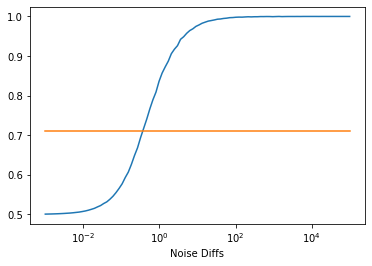

In [14]:
# plot the diffs
fig, axs = plt.subplots(1, 1)
axs.plot(k_constants, mean_probs)
print(mean_probs[32])
print(np.argmin(np.abs(mean_probs - np.mean(is_corrects))))
print(k_constants[np.argmin(np.abs(mean_probs - np.mean(is_corrects)))])
plt.xscale("log")
axs.plot([k_constants[0], k_constants[-1]], [np.mean(is_corrects), np.mean(is_corrects)])
axs.set_xlabel("K Constants")
axs.set_xlabel("Noise Diffs")
plt.show()

In [17]:
# make a normalization annealing system using something like bayesien optimization to select a normalziation
# type and a k value
# if this seems to work well we could integrate a system that learns noise constants based on the locations
# of items in latent space and incorporate this information into the selection of different queries based 
# on their expected level of informativeness
dist_diffs = []
is_correct = []
triplet_iter = 5
for trip_iter in range(triplet_iter):
    for triplet_index in tqdm(range(len(data_manager.triplet_test))):
        (anchor, positive, negative), [] = data_manager.triplet_test[triplet_index]
        # embed the triplets
        _, _, anchor_vector, _ = model.forward(anchor.cuda())
        _, _, positive_vector, _ = model.forward(positive.cuda())
        _, _, negative_vector, _ = model.forward(negative.cuda())
        anchor_vector = anchor_vector.detach().cpu().numpy()
        positive_vector = positive_vector.detach().cpu().numpy()
        negative_vector = negative_vector.detach().cpu().numpy()
        # calculate the probability given by the logistic response model that the positive
        # vector will be the correct one
        anchor_neg = np.linalg.norm(anchor_vector - negative_vector)**2
        anchor_pos = np.linalg.norm(anchor_vector - positive_vector)**2
        is_correct.append(1.0 if anchor_neg > anchor_pos else 0.0)
        dist_diffs.append(anchor_neg - anchor_pos)


100%|██████████| 1135/1135 [00:05<00:00, 200.35it/s]

0.5372415431595692
0.6223996058371887
0.6596516741567113


In [26]:
mean_probs = []
k_constants = np.logspace(-2, 2, num=100)
for k in k_constants:
    probs = sigmoid(np.array(dist_diffs) * k)
    probs = 2 * np.abs(probs - 0.5)
    prob = np.mean(probs)
    mean_probs.append(prob)

/storage/home/hcoda1/9/ahelbling6/.conda/envs/latent/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


51
1.149756995397737


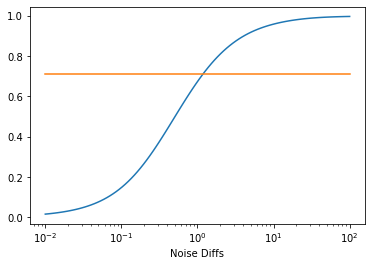

In [27]:
# plot the diffs
fig, axs = plt.subplots(1, 1)
axs.plot(k_constants, mean_probs)
print(np.argmin(np.abs(mean_probs - np.mean(is_corrects))))
print(k_constants[np.argmin(np.abs(mean_probs - np.mean(is_corrects)))])
plt.xscale("log")
axs.plot([k_constants[0], k_constants[-1]], [np.mean(is_corrects), np.mean(is_corrects)])
axs.set_xlabel("K Constants")
axs.set_xlabel("Noise Diffs")
plt.show()

In [ ]:
mean_probs = []
k_constants = np.logspace(-2, 2, num=100)
diffs = dist_diffs
for k in k_constants:
    diffs = dist_dic
    probs = sigmoid(np.array(dist_diffs) * k)
    probs = 2 * np.abs(probs - 0.5)
    prob = np.mean(probs)
    mean_probs.append(prob)

In [ ]:
# plot the diffs
fig, axs = plt.subplots(1, 1)
axs.plot(k_constants, mean_probs)
print(np.argmin(np.abs(mean_probs - np.mean(is_corrects))))
print(k_constants[np.argmin(np.abs(mean_probs - np.mean(is_corrects)))])
plt.xscale("log")
axs.plot([k_constants[0], k_constants[-1]], [np.mean(is_corrects), np.mean(is_corrects)])
axs.set_xlabel("K Constants")
axs.set_xlabel("Noise Diffs")
plt.show()

In [31]:
# make a normalization annealing system using something like bayesien optimization to select a normalziation
# type and a k value
# if this seems to work well we could integrate a system that learns noise constants based on the locations
# of items in latent space and incorporate this information into the selection of different queries based 
# on their expected level of informativeness
dist_diffs = []
is_correct = []
normalization_values = []
triplet_iter = 5
for trip_iter in range(triplet_iter):
    for triplet_index in tqdm(range(len(data_manager.triplet_test))):
        (anchor, positive, negative), [] = data_manager.triplet_test[triplet_index]
        # embed the triplets
        _, _, anchor_vector, _ = model.forward(anchor.cuda())
        _, _, positive_vector, _ = model.forward(positive.cuda())
        _, _, negative_vector, _ = model.forward(negative.cuda())
        anchor_vector = anchor_vector.detach().cpu().numpy()
        positive_vector = positive_vector.detach().cpu().numpy()
        negative_vector = negative_vector.detach().cpu().numpy()
        # calculate the probability given by the logistic response model that the positive
        # vector will be the correct one
        anchor_neg = np.linalg.norm(anchor_vector - negative_vector)**2
        anchor_pos = np.linalg.norm(anchor_vector - positive_vector)**2
        normalization_value = 2*np.linalg.norm(positive_vector - negative_vector)
        normalization_values.append(normalization_value)
        is_correct.append(1.0 if anchor_neg > anchor_pos else 0.0)
        dist_diffs.append(anchor_neg - anchor_pos)


100%|██████████| 1135/1135 [00:05<00:00, 202.44it/s]


In [42]:
mean_probs = []
k_constants = np.logspace(-3, 3, num=100)
diffs = dist_diffs
for k in k_constants:
    probs = sigmoid(np.array(dist_diffs) * k / normalization_values) 
    probs = 2 * np.abs(probs - 0.5)
    prob = np.mean(probs)
    mean_probs.append(prob)

/storage/home/hcoda1/9/ahelbling6/.conda/envs/latent/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


57
2.848035868435802


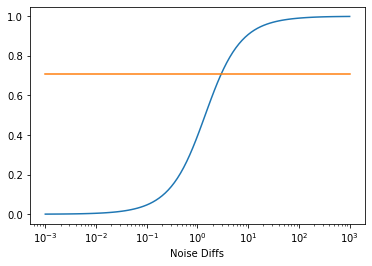

In [43]:
# plot the diffs
fig, axs = plt.subplots(1, 1)
axs.plot(k_constants, mean_probs)
print(np.argmin(np.abs(mean_probs - np.mean(is_corrects))))
print(k_constants[np.argmin(np.abs(mean_probs - np.mean(is_corrects)))])
plt.xscale("log")
axs.plot([k_constants[0], k_constants[-1]], [np.mean(is_corrects), np.mean(is_corrects)])
axs.set_xlabel("K Constants")
axs.set_xlabel("Noise Diffs")
plt.show()

In [ ]:
# given a triplet
# what is the probability that the anchor is your ideal point given the positive 
# is more similar to the anchor than the negative
# we want to maximize this probability by altering the k value
# we want to do this over a set of triplets

### Find K that maximizes likelihood on average

In [30]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# calculate likelihood
def calculate_likelihood(squared_distance, pos_neg_distance, k_constant, normalization="normalized"):
    if normalization is "constant":
        return sigmoid(k_constant * squared_distance)
    elif normalization is "normalized":
        return sigmoid(k_constant * squared_distance / (2 * pos_neg_distance))
    elif normalization is "decaying":
        return 0.0
    else:
        raise Exception("Unrecognized normalization")
        
def calculate_pos_neg_distance(positive, negative):
    return np.linalg.norm(positive - negative)
        
def calculate_triplet_dists(triplet_iters=5):
    dist_diffs = []
    pos_neg_distances = []
    for trip_iter in range(triplet_iters):
        for triplet_index in tqdm(range(len(data_manager.triplet_test)), position=0, leave=True):
            (anchor, positive, negative), [] = data_manager.triplet_test[triplet_index]
            # embed the triplets
            _, _, anchor_vector, _ = model.forward(anchor.cuda())
            _, _, positive_vector, _ = model.forward(positive.cuda())
            _, _, negative_vector, _ = model.forward(negative.cuda())
            anchor_vector = anchor_vector.detach().cpu().numpy()
            positive_vector = positive_vector.detach().cpu().numpy()
            negative_vector = negative_vector.detach().cpu().numpy()
            # calculate the distances
            anchor_neg = np.linalg.norm(anchor_vector - negative_vector)**2
            anchor_pos = np.linalg.norm(anchor_vector - positive_vector)**2
            dist_diffs.append(anchor_neg - anchor_pos)
            pos_neg_distance = calculate_pos_neg_distance(positive_vector, negative_vector)
            pos_neg_distances.append(pos_neg_distance)
    
    return dist_diffs, pos_neg_distances
        
def calculate_likelihood_for_k_range(k_range, triplet_iters=5, normalization="normalized"):
    # calculate all of the distances pre-sigmoid
    squared_dists, pos_neg_dists = calculate_triplet_dists(triplet_iters=triplet_iters)
    # for each k_range
    mean_probs = []
    for k_constant in k_range:
        probs = []
        # go through each triplet_dist
        for i in range(len(squared_dists)):
            squared_dist = squared_dists[i]
            pos_neg_distance = pos_neg_dists[i]
            prob = calculate_likelihood(squared_dist, pos_neg_distance, k_constant, normalization=normalization)
            probs.append(prob)
        mean_probs.append(np.mean(probs))
    return mean_probs

In [31]:
k_range = np.logspace(-3, 5, num=100)
mean_probs = calculate_likelihood_for_k_range(k_range, triplet_iters=5, normalization="normalized")

100%|██████████| 1135/1135 [00:06<00:00, 185.35it/s]
/storage/home/hcoda1/9/ahelbling6/.conda/envs/latent/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


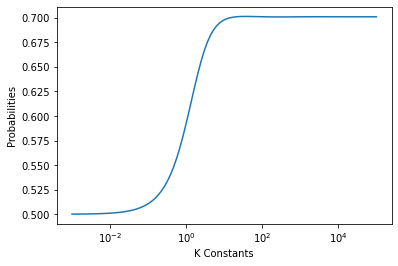

In [34]:
# plot the mean_probs
# plot the diffs
fig, axs = plt.subplots(1, 1)
axs.plot(k_range, mean_probs)
plt.xscale("log")
axs.set_xlabel("K Constants")
axs.set_ylabel("Probabilities")
plt.show()

In [ ]:
# predict an expected noise constant for each query pair, using triplets
# as the training data 
# this could be trained after the model is trained, but before localization
# train a function f(p, q) -> k that takes in the two vectors for a query and outputs 
# an optimal k value 
# this could even maybe be incorporated into training, biasing towards training on triplets
# that are expected to be incorrect